In [1]:
#!pip install arviz
#!pip install pymc3
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from IPython.display import Markdown as md

from scipy import stats
from scipy.special import expit as logistic
import seaborn as sns

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89
az.rcParams["stats.ic_scale"] = "deviance"
az.rcParams["stats.information_criterion"] = "waic"

## The goal here is to compare the electric field (EF) estimations across two separate instances, once with Roast 1.1 and once with Roast 3.0 -reading data in

In [3]:
import os
os.chdir('/ECT/Bergen/Compare11vs30/')
#dfef = pd.read_csv("./2022-05-27@19-05-18_cmpef.csv", sep=",")
dfef = pd.read_csv("./2022-05-31@20-30-18_cmpef.csv", sep=",")
dfef

Unnamed: 0       id                  roicf                 roi  \
0              1  G100104       EF_3rd.Ventricle       3rd-Ventricle   
1              2  G100104       EF_4th.Ventricle       4th-Ventricle   
2              3  G100104          EF_Brain.Stem          Brain-Stem   
3              4  G100104         EF_CC_Anterior         CC_Anterior   
4              5  G100104          EF_CC_Central          CC_Central   
...          ...      ...                    ...                 ...   
6906        6907  G137482      EF_Right.Pallidum      Right-Pallidum   
6907        6908  G137482       EF_Right.Putamen       Right-Putamen   
6908        6909  G137482     EF_Right.VentralDC     Right-VentralDC   
6909        6910  G137482        EF_Right.vessel        Right-vessel   
6910        6911  G137482  EF_WM.hypointensities  WM-hypointensities   

          mean    stdev      min       max     range      ef sex  age    ef11  \
0      62.4426  13.2076  35.8359  101.0569   65.2210   72.96   F   29   72.96   
1      37.6499   8.1465  25.4670   58.9128   33.4458   46.48   F   29   46.48   
2      59.9134  13.2444  33.5857   86.4841   52.8983   67.76   F   29   67.76   
3      90.9618   4.9549  78.9790  102.4376   23.4587   94.16   F   29   94.16   
4      96.6774  33.6801  47.5351  145.1185   97.5834  104.64   F   29  104.64   
...        ...      ...      ...       ...       ...     ...  ..  ...     ...   
6906   99.1520   8.9288  78.1530  116.7636   38.6106  141.75   F   83  141.75   
6907  106.5002  15.0809  77.7839  144.2562   66.4723  130.77   F   83  130.77   
6908   78.3910  12.9718  51.8609  108.4424   56.5815  125.37   F   83  125.37   
6909   92.1668  10.3125  81.3804  114.8625   33.4821  103.41   F   83  103.41   
6910   87.1574  36.8762  23.8911  165.3511  141.4601  121.68   F   83  121.68   

          ef30  
0      62.4426  
1      37.6499  
2      59.9134  
3      90.9618  
4      96.6774  
...        ...  
6906   99.1520  
6907  106.5002  
6908   78.3910  
6909   92.1668  
6910   87.1574  

[6911 rows x 14 columns]

In [4]:
md("####  I had N={} subjects where both ways were calculated, this is only RUL".format(np.unique(dfef.id).size))

####  I had N=64 subjects where both ways were calculated, this is only RUL

In [5]:
datafref = dfef.iloc[np.where((dfef.ef30.notnull()) & (dfef.roicf!='EF_non.WM.hypointensities') & (dfef.roicf!='EF_WM.hypointensities'))].copy()
datafref.shape

(6783, 14)

Delta Volume

In [6]:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%qtconsole

In [7]:
Nsubj = len(np.unique(datafref.id))
code = pd.DataFrame({'id':list(np.unique(datafref.id)), 'sbj':list(range(Nsubj))})
datafref['sbj'] = np.zeros(datafref.shape[0]).astype(int)

for i in range(Nsubj):
    indx = np.where(datafref.id == code.id[i])
    datafref.sbj.iloc[indx[0]] = code.sbj[i]
datafref


/tmp/ipykernel_25/1462623132.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafref.sbj.iloc[indx[0]] = code.sbj[i]


Unnamed: 0       id                       roicf  \
0              1  G100104            EF_3rd.Ventricle   
1              2  G100104            EF_4th.Ventricle   
2              3  G100104               EF_Brain.Stem   
3              4  G100104              EF_CC_Anterior   
4              5  G100104               EF_CC_Central   
...          ...      ...                         ...   
6905        6906  G137482  EF_Right.Lateral.Ventricle   
6906        6907  G137482           EF_Right.Pallidum   
6907        6908  G137482            EF_Right.Putamen   
6908        6909  G137482          EF_Right.VentralDC   
6909        6910  G137482             EF_Right.vessel   

                          roi      mean    stdev      min       max    range  \
0               3rd-Ventricle   62.4426  13.2076  35.8359  101.0569  65.2210   
1               4th-Ventricle   37.6499   8.1465  25.4670   58.9128  33.4458   
2                  Brain-Stem   59.9134  13.2444  33.5857   86.4841  52.8983   
3                 CC_Anterior   90.9618   4.9549  78.9790  102.4376  23.4587   
4                  CC_Central   96.6774  33.6801  47.5351  145.1185  97.5834   
...                       ...       ...      ...      ...       ...      ...   
6905  Right-Lateral-Ventricle   41.8565  12.4576  21.9105   82.0907  60.1802   
6906           Right-Pallidum   99.1520   8.9288  78.1530  116.7636  38.6106   
6907            Right-Putamen  106.5002  15.0809  77.7839  144.2562  66.4723   
6908          Right-VentralDC   78.3910  12.9718  51.8609  108.4424  56.5815   
6909             Right-vessel   92.1668  10.3125  81.3804  114.8625  33.4821   

          ef sex  age    ef11      ef30  sbj  
0      72.96   F   29   72.96   62.4426    0  
1      46.48   F   29   46.48   37.6499    0  
2      67.76   F   29   67.76   59.9134    0  
3      94.16   F   29   94.16   90.9618    0  
4     104.64   F   29  104.64   96.6774    0  
...      ...  ..  ...     ...       ...  ...  
6905   65.25   F   83   65.25   41.8565   63  
6906  141.75   F   83  141.75   99.1520   63  
6907  130.77   F   83  130.77  106.5002   63  
6908  125.37   F   83  125.37   78.3910   63  
6909  103.41   F   83  103.41   92.1668   63  

[6783 rows x 15 columns]

In [8]:
demog = pd.DataFrame({'age': datafref.age, 'sex': datafref.sex, 'sbj':datafref.sbj}).drop_duplicates()

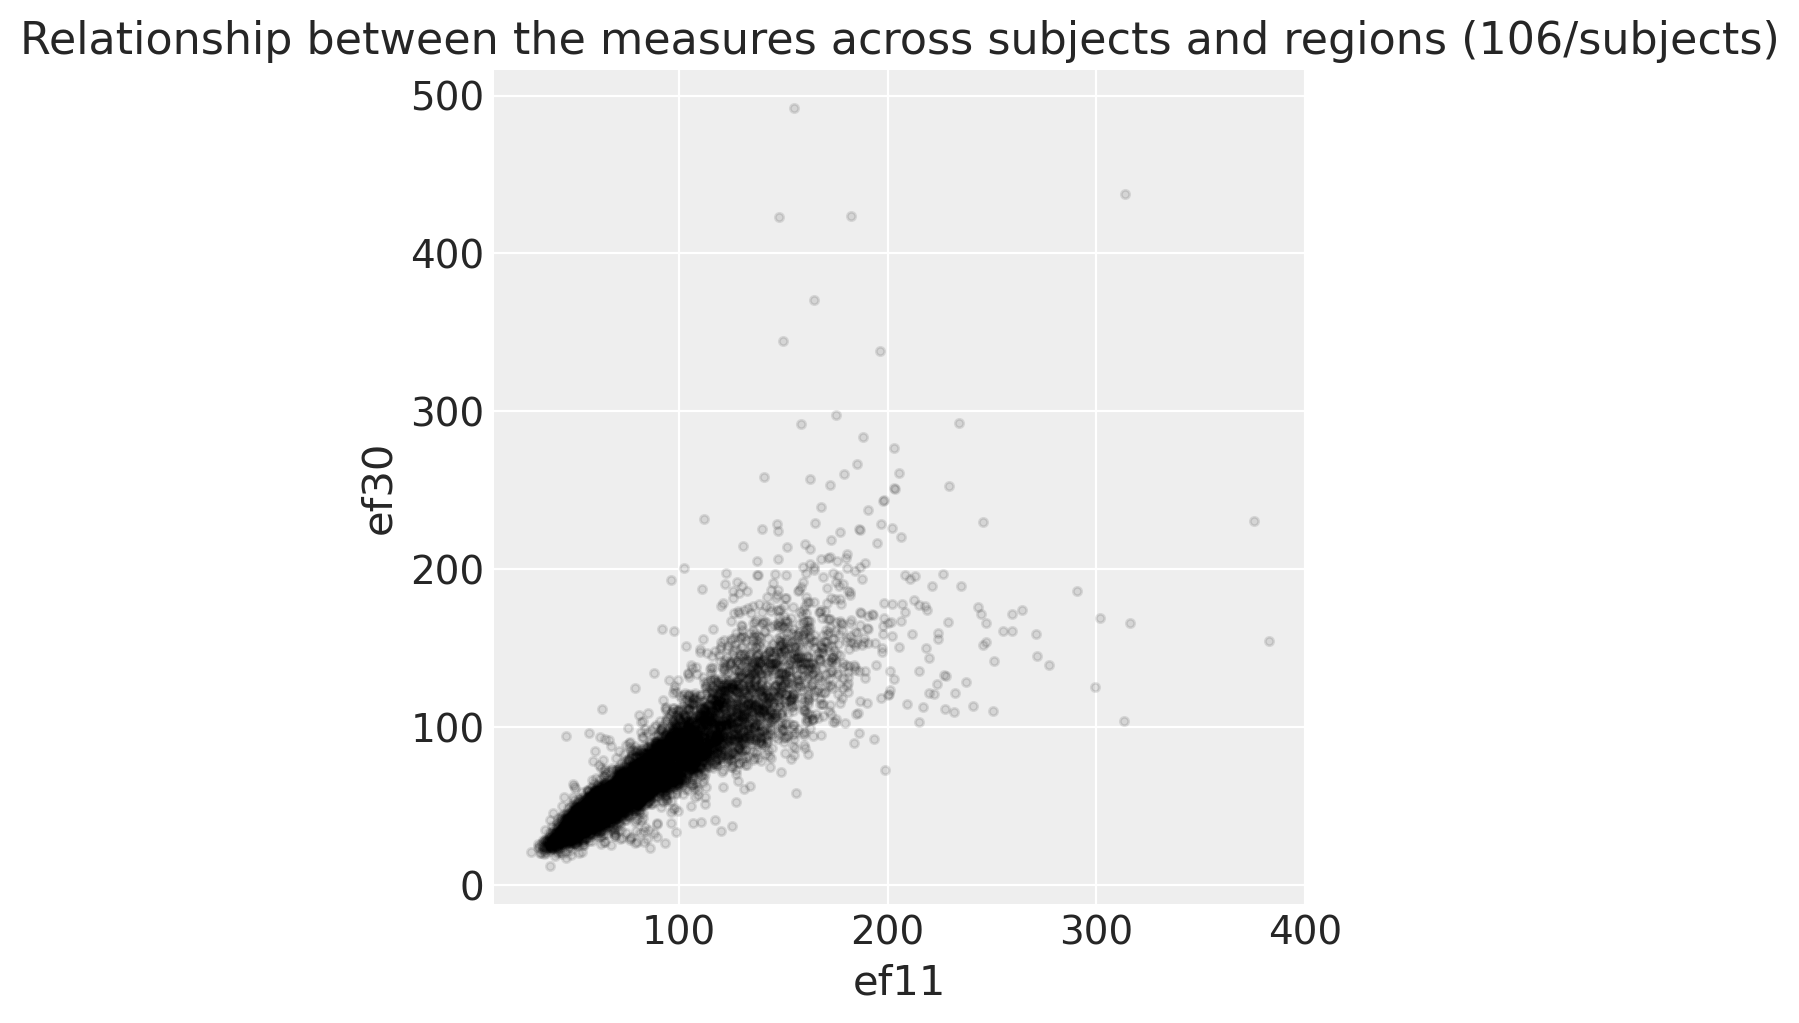

In [11]:
plt.rcParams['figure.figsize'] = (5,5);
fig, ax = plt.subplots(1,1)

ax.plot(datafref.ef11, datafref.ef30, ".k", alpha=0.1)
ax.set_xlabel("ef11")
ax.set_ylabel("ef30")
ax.set_title("Relationship between the measures across subjects and regions (106/subjects)");


### First model, when the clustering variable is the individual: $ef30 = b * ef11 + \epsilon$ - no intercept

In [12]:
sbj=datafref.sbj.astype(int).values
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
#ef=ss.fit_transform(nmdata['Max_Intensity.1'].values.reshape(-1,1)).ravel()#remove extra bracket
#vol=ss.fit_transform(nmdata['dvol'].values.reshape(-1,1)).ravel() #remove extra bracket

with pm.Model() as c_1_1:
    # hyper-priors
    ef11=pm.Data('ef11', datafref.ef11)
    ef30 = pm.Data('ef30', datafref.ef30)
    #a_bar = pm.Normal("a_bar", 0.0, 100.0 )
    b_bar = pm.Normal("b_bar", 0.5,1)
    #sigma_a = pm.Exponential("sigma_a", 1.0)
    sigma_b = pm.Exponential("sigma_b", 0.5)
    sigma = pm.Exponential("sigma", 0.5)
    # adaptive priors
    #a = pm.Normal("a", a_bar, sigma_a, shape=Nsubj)
    b = pm.Normal("b", b_bar, sigma_b, shape=Nsubj)
    mu = pm.Deterministic("mu", b[sbj] * ef30)
    #mu = a[sbj] + b[sbj]*nmdata['Max_Intensity.1']
    M = pm.Normal("M", mu, sigma, observed=ef11)
    
    #trace_1_2 = pm.sample(tune=3000, target_accept=0.95, random_seed=RANDOM_SEED)
    #trace_clin_1_1 = pm.sample(random_seed=RANDOM_SEED)
    #idata_clin_1_1 = az.from_pymc3(trace_clin_1_1)

In [13]:
with c_1_1:
    prior =  pm.sample_prior_predictive()
    trace = pm.sample(tune=3000, random_seed=RANDOM_SEED)
    ppc = pm.sample_posterior_predictive(trace)
    c_1_1_idata = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=ppc)

/opt/conda/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, sigma, sigma_b, b_bar]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 51 seconds.


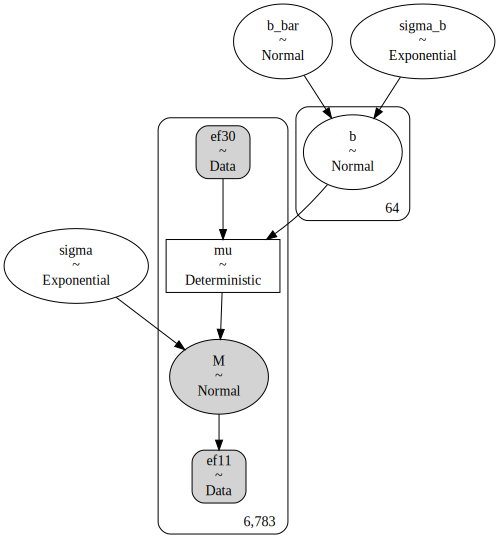

In [17]:
pm.model_graph.model_to_graphviz(c_1_1, formatting='plain')

In [18]:
ind_avg = c_1_1_idata['posterior']['b'].mean(dim=['chain','draw']).values
ind_std = c_1_1_idata['posterior']['b'].std(dim=['chain','draw']).values
ICt = pd.DataFrame({'avg': ind_avg, 'std': ind_std, 'sbj': range(len(ind_avg))})
IC = pd.merge(ICt, demog, left_on='sbj', right_on='sbj')

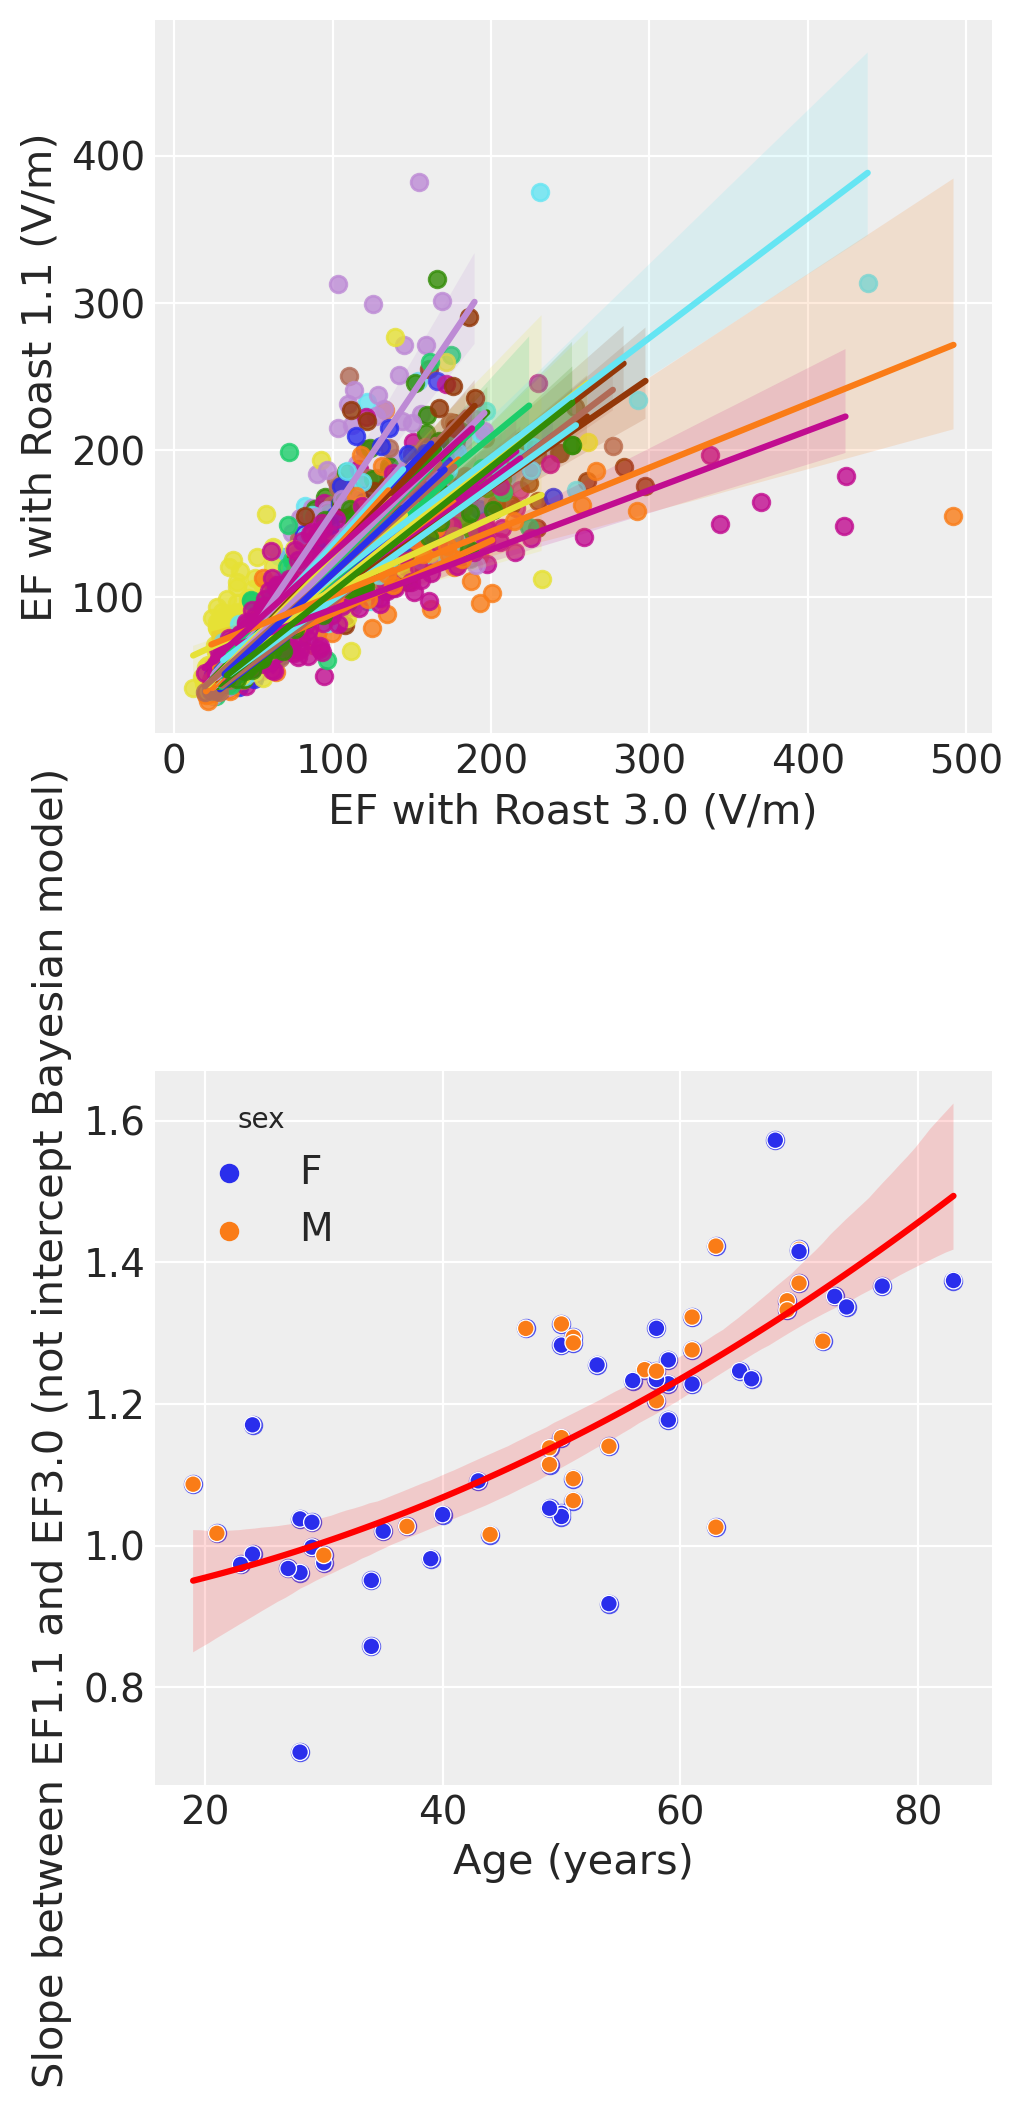

In [20]:
plt.rcParams['figure.figsize'] = (5,10);
fix, axes = plt.subplots(2,1);
for i in range(64):
    sns.regplot(data=datafref.iloc[np.where(datafref.sbj==i)], y='ef11', x='ef30', ax=axes[0]);
sns.regplot(data=IC, x='age', y='avg', line_kws={'color':'r'}, order=2, ax=axes[1]);
sns.scatterplot(data=IC, x='age', y='avg', hue='sex', ax=axes[1]);
axes[0].set_ylabel('EF with Roast 1.1 (V/m)')
axes[0].set_xlabel('EF with Roast 3.0 (V/m)')
axes[1].set_xlabel('Age (years)')
axes[1].set_ylabel('Slope between EF1.1 and EF3.0 (not intercept Bayesian model)')
plt.savefig('/ECT/Bergen/Compare11vs30/individual-differencies-are-related-to-age.pdf');
plt.show();


Conclusion
***
The model works well without intercept (note that in the figure I used the regplot function that uses intercept, that in itself shows that most of th line had intercept zero or close to that), and the slope is related to the age, meaning that in the age range between ages 20 and 50 we have a good one to one relationship. However as subjects gets older EF3.0 provides correspondingly higher values...

### Second model, when the clustering variable is the region: $ef30 = b * ef11 + \epsilon$ - no intercept

In [21]:
Nroi = len(np.unique(datafref.roicf))
coder = pd.DataFrame({'id':list(np.unique(datafref.roicf)), 'roi':list(range(Nroi))})
datafref['roiind'] = np.zeros(datafref.shape[0]).astype(int)

for i in range(Nroi):
    indx = np.where(datafref.roicf == coder.id[i])
    datafref.roiind.iloc[indx[0]] = coder.roi[i]
datafref

/tmp/ipykernel_25/3656502557.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafref.roiind.iloc[indx[0]] = coder.roi[i]


Unnamed: 0       id                       roicf  \
0              1  G100104            EF_3rd.Ventricle   
1              2  G100104            EF_4th.Ventricle   
2              3  G100104               EF_Brain.Stem   
3              4  G100104              EF_CC_Anterior   
4              5  G100104               EF_CC_Central   
...          ...      ...                         ...   
6905        6906  G137482  EF_Right.Lateral.Ventricle   
6906        6907  G137482           EF_Right.Pallidum   
6907        6908  G137482            EF_Right.Putamen   
6908        6909  G137482          EF_Right.VentralDC   
6909        6910  G137482             EF_Right.vessel   

                          roi      mean    stdev      min       max    range  \
0               3rd-Ventricle   62.4426  13.2076  35.8359  101.0569  65.2210   
1               4th-Ventricle   37.6499   8.1465  25.4670   58.9128  33.4458   
2                  Brain-Stem   59.9134  13.2444  33.5857   86.4841  52.8983   
3                 CC_Anterior   90.9618   4.9549  78.9790  102.4376  23.4587   
4                  CC_Central   96.6774  33.6801  47.5351  145.1185  97.5834   
...                       ...       ...      ...      ...       ...      ...   
6905  Right-Lateral-Ventricle   41.8565  12.4576  21.9105   82.0907  60.1802   
6906           Right-Pallidum   99.1520   8.9288  78.1530  116.7636  38.6106   
6907            Right-Putamen  106.5002  15.0809  77.7839  144.2562  66.4723   
6908          Right-VentralDC   78.3910  12.9718  51.8609  108.4424  56.5815   
6909             Right-vessel   92.1668  10.3125  81.3804  114.8625  33.4821   

          ef sex  age    ef11      ef30  sbj  roiind  
0      72.96   F   29   72.96   62.4426    0       0  
1      46.48   F   29   46.48   37.6499    0       1  
2      67.76   F   29   67.76   59.9134    0       2  
3      94.16   F   29   94.16   90.9618    0       3  
4     104.64   F   29  104.64   96.6774    0       4  
...      ...  ..  ...     ...       ...  ...     ...  
6905   65.25   F   83   65.25   41.8565   63      32  
6906  141.75   F   83  141.75   99.1520   63      33  
6907  130.77   F   83  130.77  106.5002   63      34  
6908  125.37   F   83  125.37   78.3910   63      35  
6909  103.41   F   83  103.41   92.1668   63      37  

[6783 rows x 16 columns]

In [22]:
roiind=datafref.roiind.astype(int).values
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
#ef=ss.fit_transform(nmdata['Max_Intensity.1'].values.reshape(-1,1)).ravel()#remove extra bracket
#vol=ss.fit_transform(nmdata['dvol'].values.reshape(-1,1)).ravel() #remove extra bracket

with pm.Model() as c_1_2:
    # hyper-priors
    ef11=pm.Data('ef11', datafref.ef11)
    ef30 = pm.Data('ef30', datafref.ef30)
    #a_bar = pm.Normal("a_bar", 0.0, 100.0 )
    b_bar = pm.Normal("b_bar", 0.5,1)
    #sigma_a = pm.Exponential("sigma_a", 1.0)
    sigma_b = pm.Exponential("sigma_b", 0.5)
    sigma = pm.Exponential("sigma", 0.5)
    # adaptive priors
    #a = pm.Normal("a", a_bar, sigma_a, shape=Nsubj)
    b = pm.Normal("b", b_bar, sigma_b, shape=Nroi)
    mu = pm.Deterministic("mu", b[roiind] * ef30)
    #mu = a[sbj] + b[sbj]*nmdata['Max_Intensity.1']
    M = pm.Normal("M", mu, sigma, observed=ef11)

In [23]:
with c_1_2:
    prior =  pm.sample_prior_predictive()
    trace = pm.sample(tune=3000, random_seed=RANDOM_SEED)
    ppc = pm.sample_posterior_predictive(trace)
    c_1_2_idata = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=ppc)

/opt/conda/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, sigma, sigma_b, b_bar]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 42 seconds.


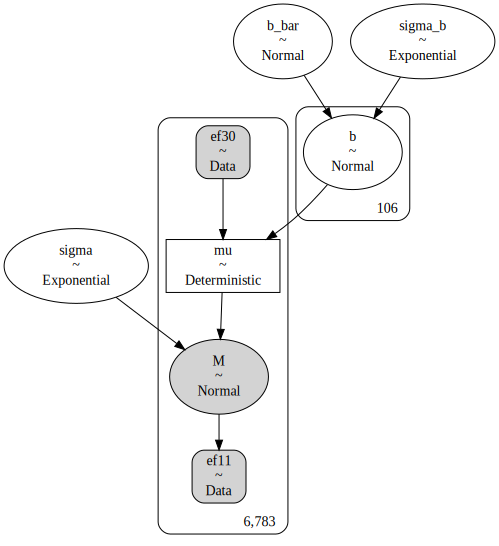

In [24]:
pm.model_graph.model_to_graphviz(c_1_2, formatting='plain')

In [25]:
cor_b = c_1_2_idata['posterior']['b'].mean(dim=['chain','draw']).values
RC = pd.DataFrame({'b':cor_b})
RC['vox']=pd.NA
RC['side']=pd.NA
RC['bols']=pd.NA
RC['roi']=pd.NA

RC.head()

b   vox  side  bols   roi
0  1.282090  <NA>  <NA>  <NA>  <NA>
1  1.287492  <NA>  <NA>  <NA>  <NA>
2  1.251611  <NA>  <NA>  <NA>  <NA>
3  1.245433  <NA>  <NA>  <NA>  <NA>
4  1.105853  <NA>  <NA>  <NA>  <NA>

In [26]:
from nilearn import image
template_data = image.get_data('/ECT/Abbott/template.nii.gz')
template_data.shape


code = pd.read_csv('/ECT/Abbott/FsTutorial_AnatomicalROI_FreeSurferColorLUT.csv')
code.head()
coder['roiname']=coder.id.str.replace('EF_','', regex=True).str.replace('.','-', regex=True)
coder.head()

(256, 256, 256)

Unnamed: 0  struct_index                 struct_name    r    g    b  a
0           1             0                     Unknown    0    0    0  0
1           2             1      Left-Cerebral-Exterior   70  130  180  0
2           3             2  Left-Cerebral-White-Matter  245  245  245  0
3           4             3        Left-Cerebral-Cortex  205   62   78  0
4           5             4      Left-Lateral-Ventricle  120   18  134  0

id  roi        roiname
0  EF_3rd.Ventricle    0  3rd-Ventricle
1  EF_4th.Ventricle    1  4th-Ventricle
2     EF_Brain.Stem    2     Brain-Stem
3    EF_CC_Anterior    3    CC_Anterior
4     EF_CC_Central    4     CC_Central

In [28]:
import statsmodels.formula.api as sfa

In [29]:
b_data=template_data.copy();
for i in np.unique(template_data):
    #print(i)
    if (i!=0):
        ixs=np.where(template_data==i)
        regt = code.struct_name.iloc[np.where(code['struct_index']==i)]
        ixs2 = np.where(coder.roiname==regt.values[0])
        if (ixs2[0].size!=0):
            k=coder.roi.iloc[ixs2].values[0]
            #b_data[ixs]=((post['b1'][k].mean().values)*1000).round().astype('int') + ((post['a1'][k].mean().values)*1000).round().astype('int')#here we multiply so that no need to deal integer/float issue
            #b_data[ixs]=((post['a1'][k].mean().values)*1000).round().astype('int')/((post['a1'][k].std().values)*1000).round().astype('int')#here we multiply so that no need to deal integer/float issue
            #b_data[ixs]=((post['a1'][k].mean().values)*1000).round().astype('int')#here we multiply so that no need to deal integer/float issue
            b_data[ixs]=((c_1_2_idata['posterior']['b'].mean(dim=['chain','draw']).values[k])*1000).round().astype('int')
            #b_data[ixs]=((c_1_3_idata['posterior']['a'].mean(dim=['chain','draw']).values[k])*1).round().astype('int')
            RC.loc[k,'vox']=ixs[0].shape[0]
            r = sfa.ols('ef11 ~ ef30 + 0', data=datafref.iloc[np.where(datafref.roiind==k)]).fit()
            RC.loc[k,'bols']=r.params[0].astype('float64')
            RC.loc[k,'roi']=regt.values[0]
            if (pd.Series(regt.values[0]).str.contains('rh').bool() | pd.Series(regt.values[0]).str.contains('Right').bool()):
                RC.loc[k, 'side']=1
            else:
                RC.loc[k, 'side']=0
            #b_data[ixs]=((ppc['b1'][:,:,2].mean(0)[k])*1000).round().astype('int')
            
        else:
            b_data[ixs]=0 #we overwrite the template data

In [30]:
from nilearn import plotting
new_image_0 = image.new_img_like('/ECT/Abbott/template.nii.gz', b_data)
new_image_0.to_filename('/ECT/Abbott/test_im0.nii.gz')
#plotting.plot_stat_map(new_image)

#### Illustration
***
Pooling - meaning that the individual clustered variables are pooled to the mean

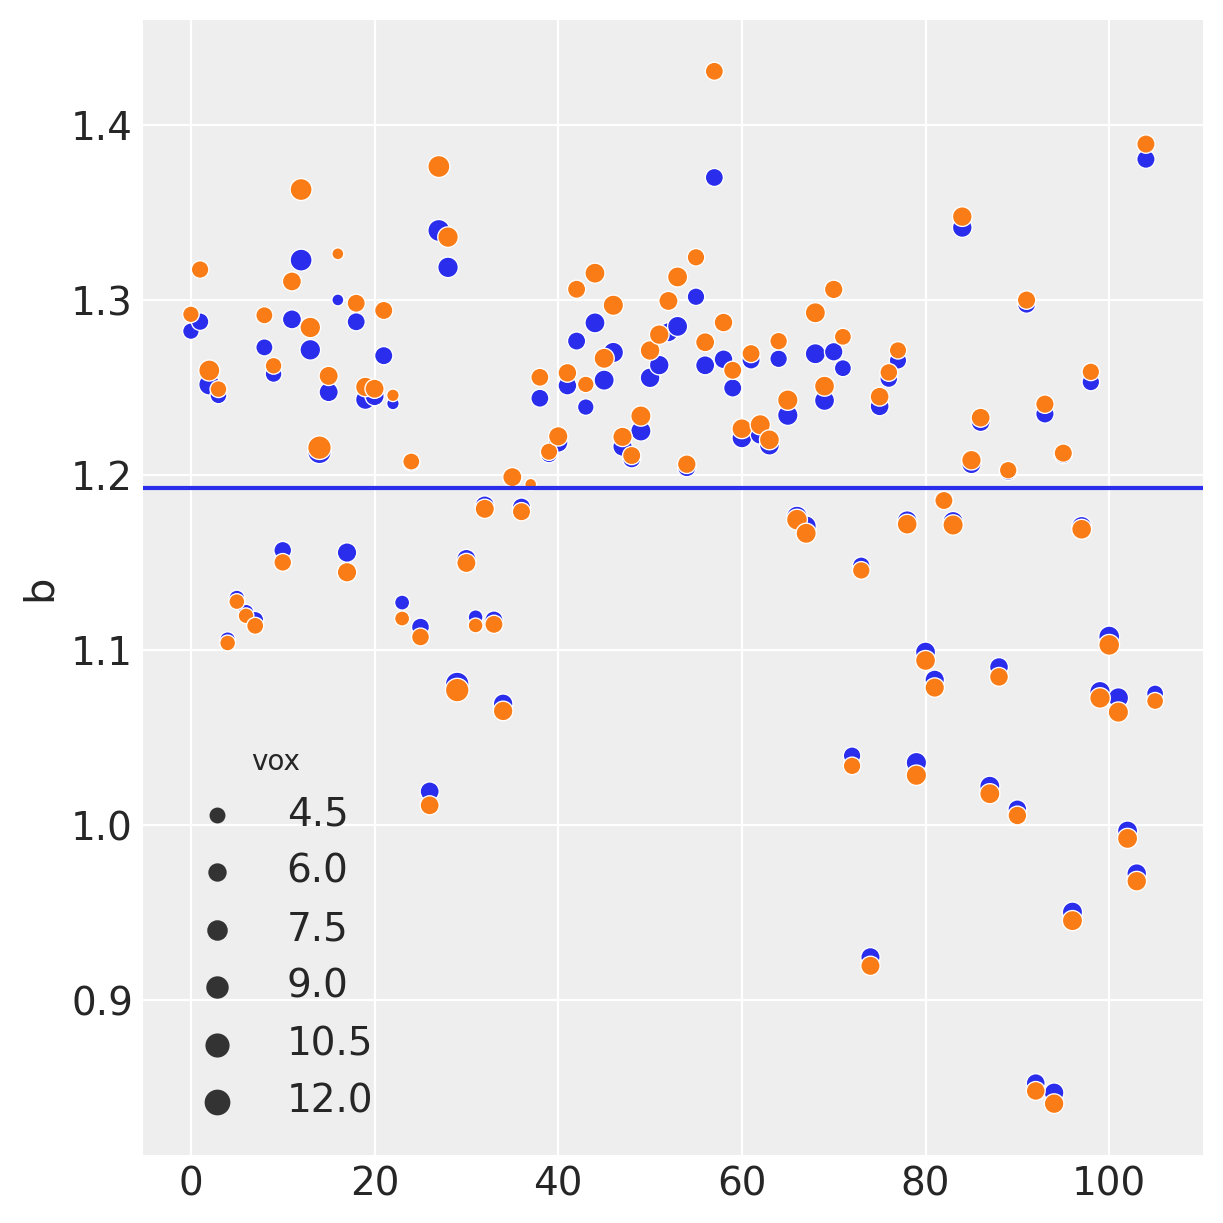

In [52]:
plt.rcParams['figure.figsize'] = (6,6);
RC['bols'] = RC['bols'].astype('float')
graph = sns.scatterplot(x=RC.index.values, y=RC.b, size=np.log(RC.vox.astype('int')));
sns.scatterplot(x=RC.index.values, y=RC.bols, size=np.log(RC.vox.astype('int')), legend=False);

graph.axhline(c_1_2_idata['posterior']['b_bar'].mean().values);

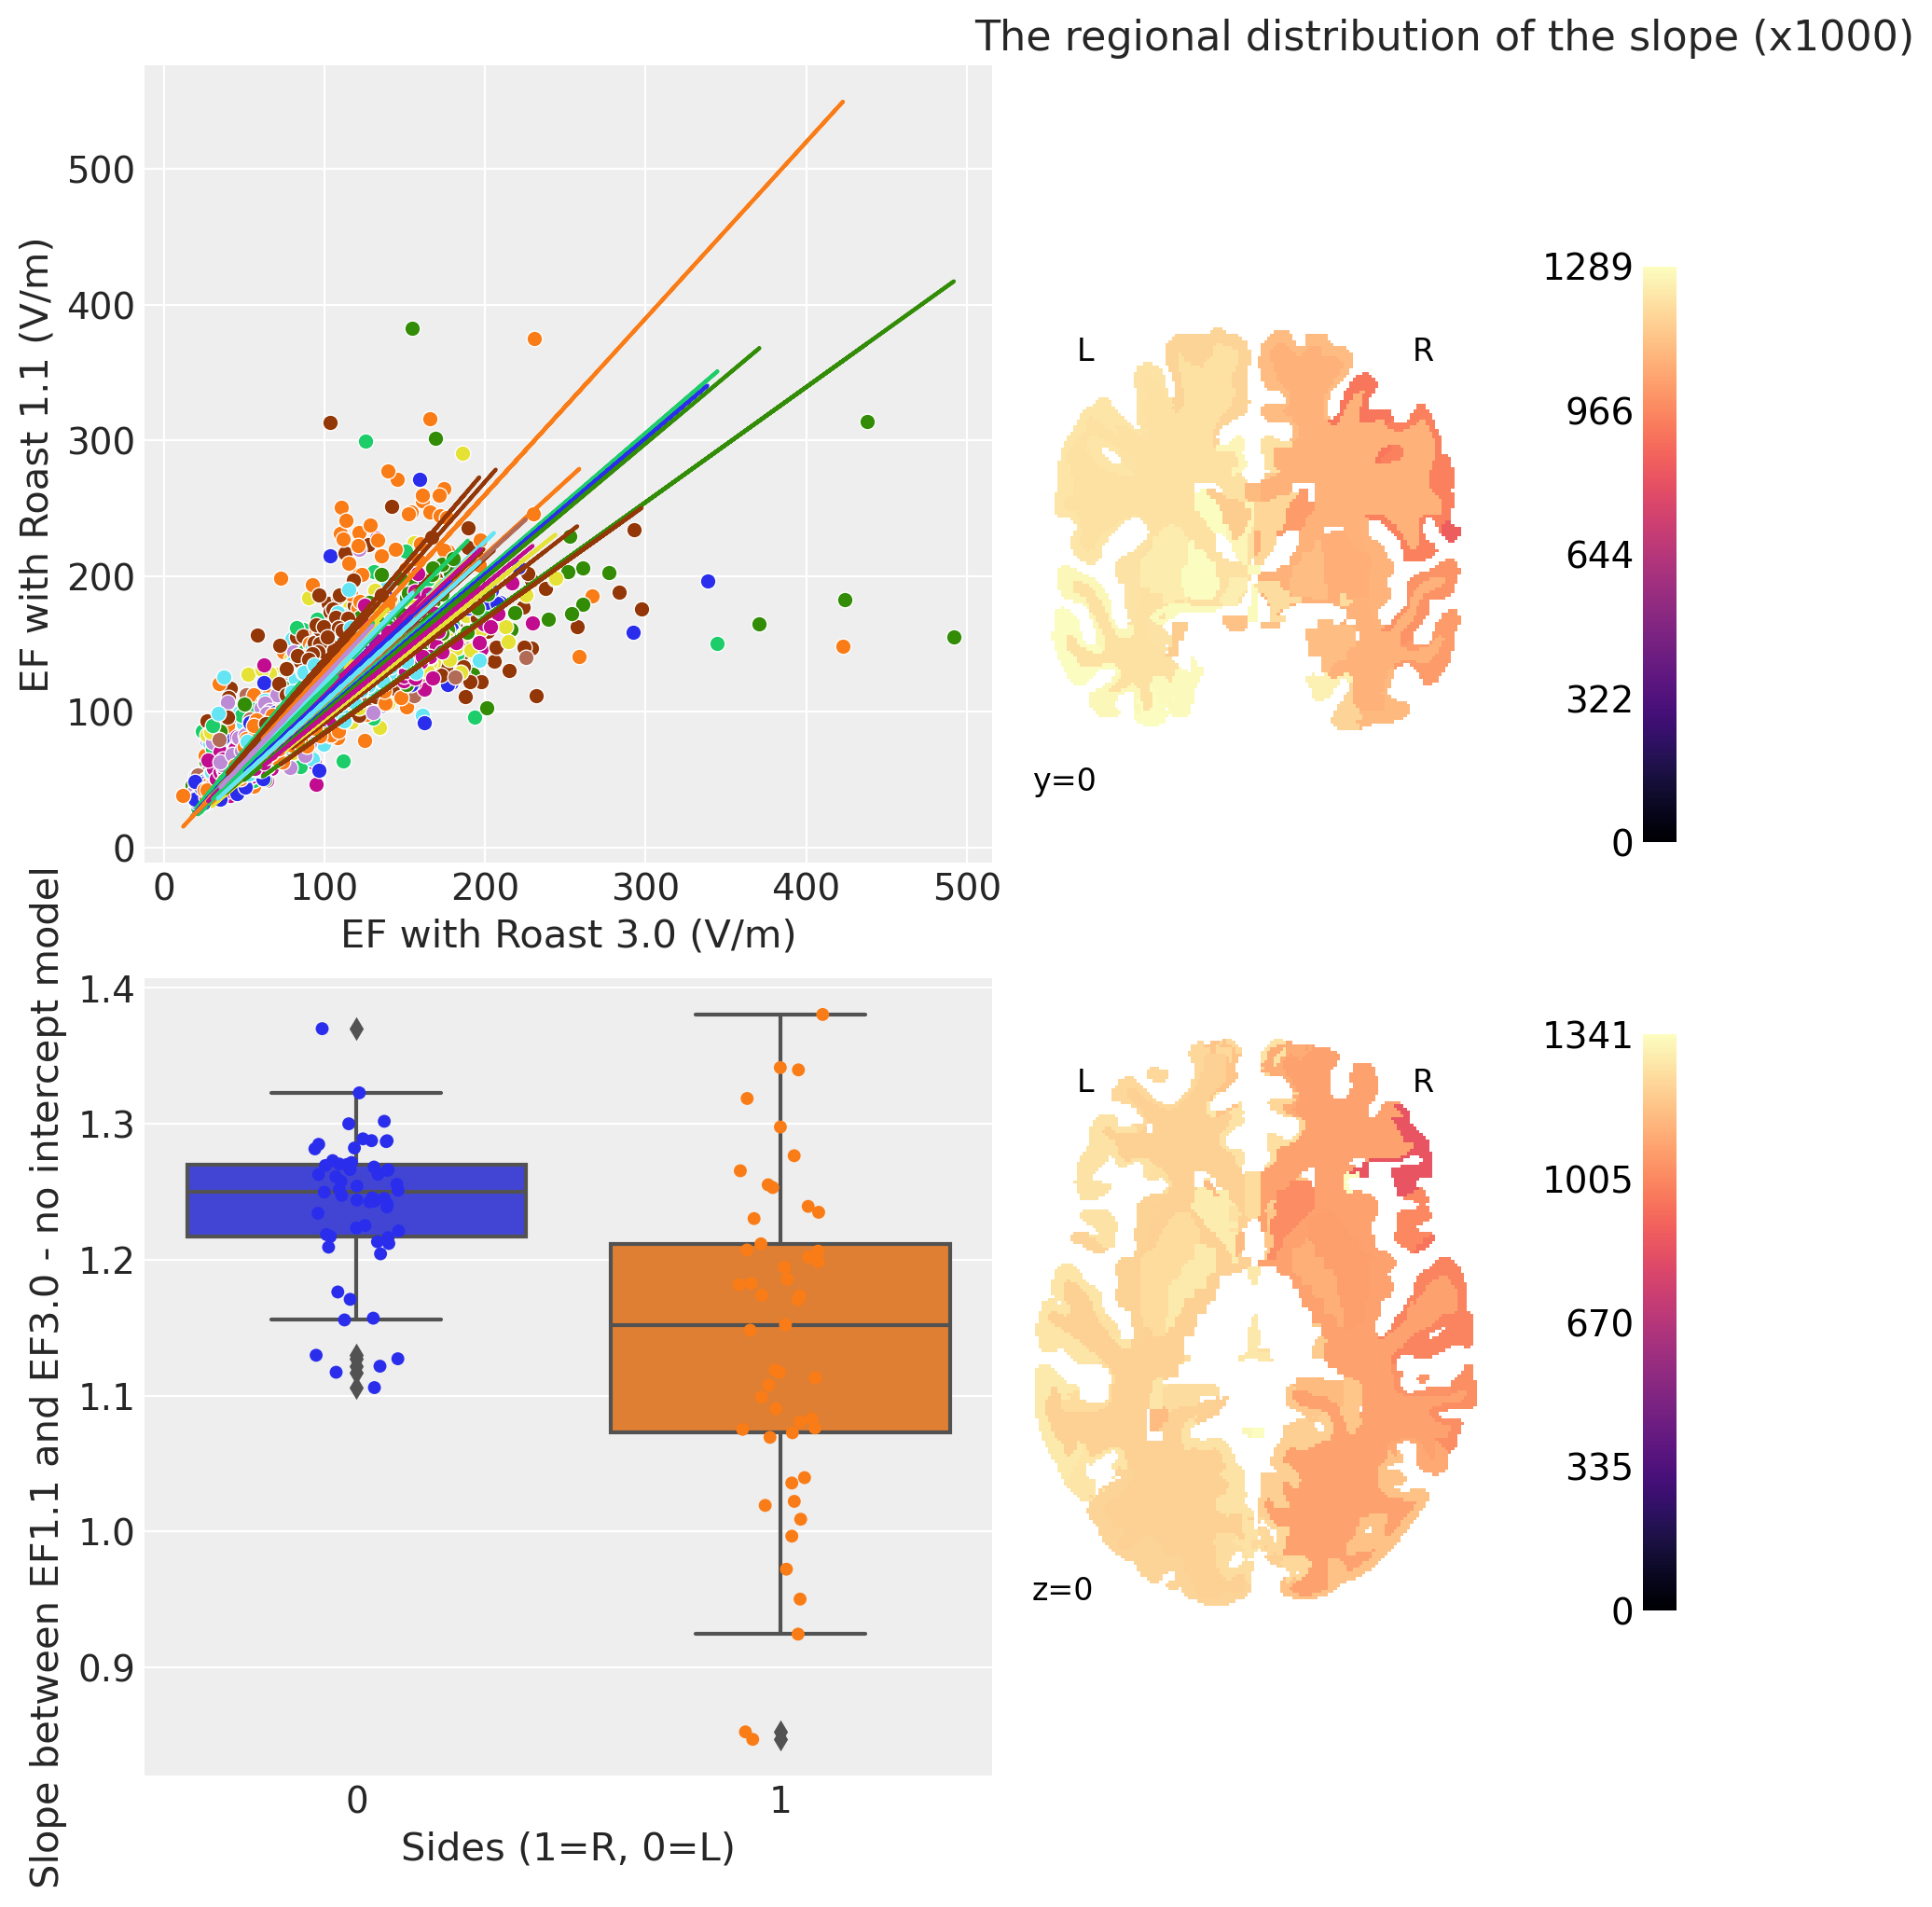

In [32]:
plt.rcParams['figure.figsize'] = (10,10);
fix, axes = plt.subplots(2,2);
for i in np.unique(datafref.roiind):
    #sns.regplot(data=datafref.iloc[np.where(datafref.roiind==i)], x='ef11', y='ef30', ax=axes[0][0], order=0);
    sns.scatterplot(data=datafref.iloc[np.where(datafref.roiind==i)], y='ef11', ax=axes[0][0], x='ef30')
    r = sfa.ols('ef11 ~ ef30 + 0', data=datafref.iloc[np.where(datafref.roiind==i)]).fit()
    axes[0][0].plot(datafref['ef30'].iloc[np.where(datafref.roiind==i)], r.fittedvalues)

sns.boxplot(data=RC, x='side', y='b', orient='v',ax=axes[1][0])
sns.stripplot(data=RC, x='side', y='b', orient='v', ax=axes[1][0])

plotting.plot_img(new_image_0, display_mode='y',cut_coords=[0], vmin=0, cmap=plt.cm.magma, threshold =0, black_bg=False, colorbar=True, draw_cross=False, cbar_tick_format="%i", axes=axes[0][1])
plotting.plot_img(new_image_0, display_mode='z',cut_coords=[0], vmin=0, cmap=plt.cm.magma, threshold =0, black_bg=False, colorbar=True, draw_cross=False, cbar_tick_format="%i", axes=axes[1][1])

axes[0][0].set_ylabel('EF with Roast 1.1 (V/m)')
axes[0][0].set_xlabel('EF with Roast 3.0 (V/m)')
axes[1][0].set_xlabel('Sides (1=R, 0=L)')
axes[1][0].set_ylabel('Slope between EF1.1 and EF3.0 - no intercept model')
axes[0][1].set_title('The regional distribution of the slope (x1000)')
#plt.savefig('/ECT/Bergen/Compare11vs30/regional-differencies-are-related-to-side.pdf');
plt.show();


### Third model, when the clustering variable is the region: $ef30 = a + b * ef11 + \epsilon$ - with intercept

In [53]:
roiind=datafref.roiind.astype(int).values
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
#ef=ss.fit_transform(nmdata['Max_Intensity.1'].values.reshape(-1,1)).ravel()#remove extra bracket
#vol=ss.fit_transform(nmdata['dvol'].values.reshape(-1,1)).ravel() #remove extra bracket

with pm.Model() as c_1_3:
    # hyper-priors
    ef11=pm.Data('ef11', datafref.ef11)
    ef30 = pm.Data('ef30', datafref.ef30)
    a_bar = pm.Normal("a_bar", 0.0, 100.0 )
    b_bar = pm.Normal("b_bar", 0.5,1)
    sigma_a = pm.Exponential("sigma_a", 0.5)
    sigma_b = pm.Exponential("sigma_b", 0.5)
    sigma = pm.Exponential("sigma", 0.5)
    # adaptive priors
    a = pm.Normal("a", a_bar, sigma_a, shape=Nroi)
    b = pm.Normal("b", b_bar, sigma_b, shape=Nroi)
    mu = pm.Deterministic("mu",a[roiind] + b[roiind] * ef30)
    #mu = a[sbj] + b[sbj]*nmdata['Max_Intensity.1']
    M = pm.Normal("M", mu, sigma, observed=ef11)

In [54]:
with c_1_3:
    prior =  pm.sample_prior_predictive()
    trace = pm.sample(tune=3000, random_seed=RANDOM_SEED)
    ppc = pm.sample_posterior_predictive(trace)
    c_1_3_idata = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=ppc)

/opt/conda/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, sigma, sigma_b, sigma_a, b_bar, a_bar]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 188 seconds.


array([<AxesSubplot:title={'center':'a_bar'}>,
       <AxesSubplot:title={'center':'b_bar'}>], dtype=object)

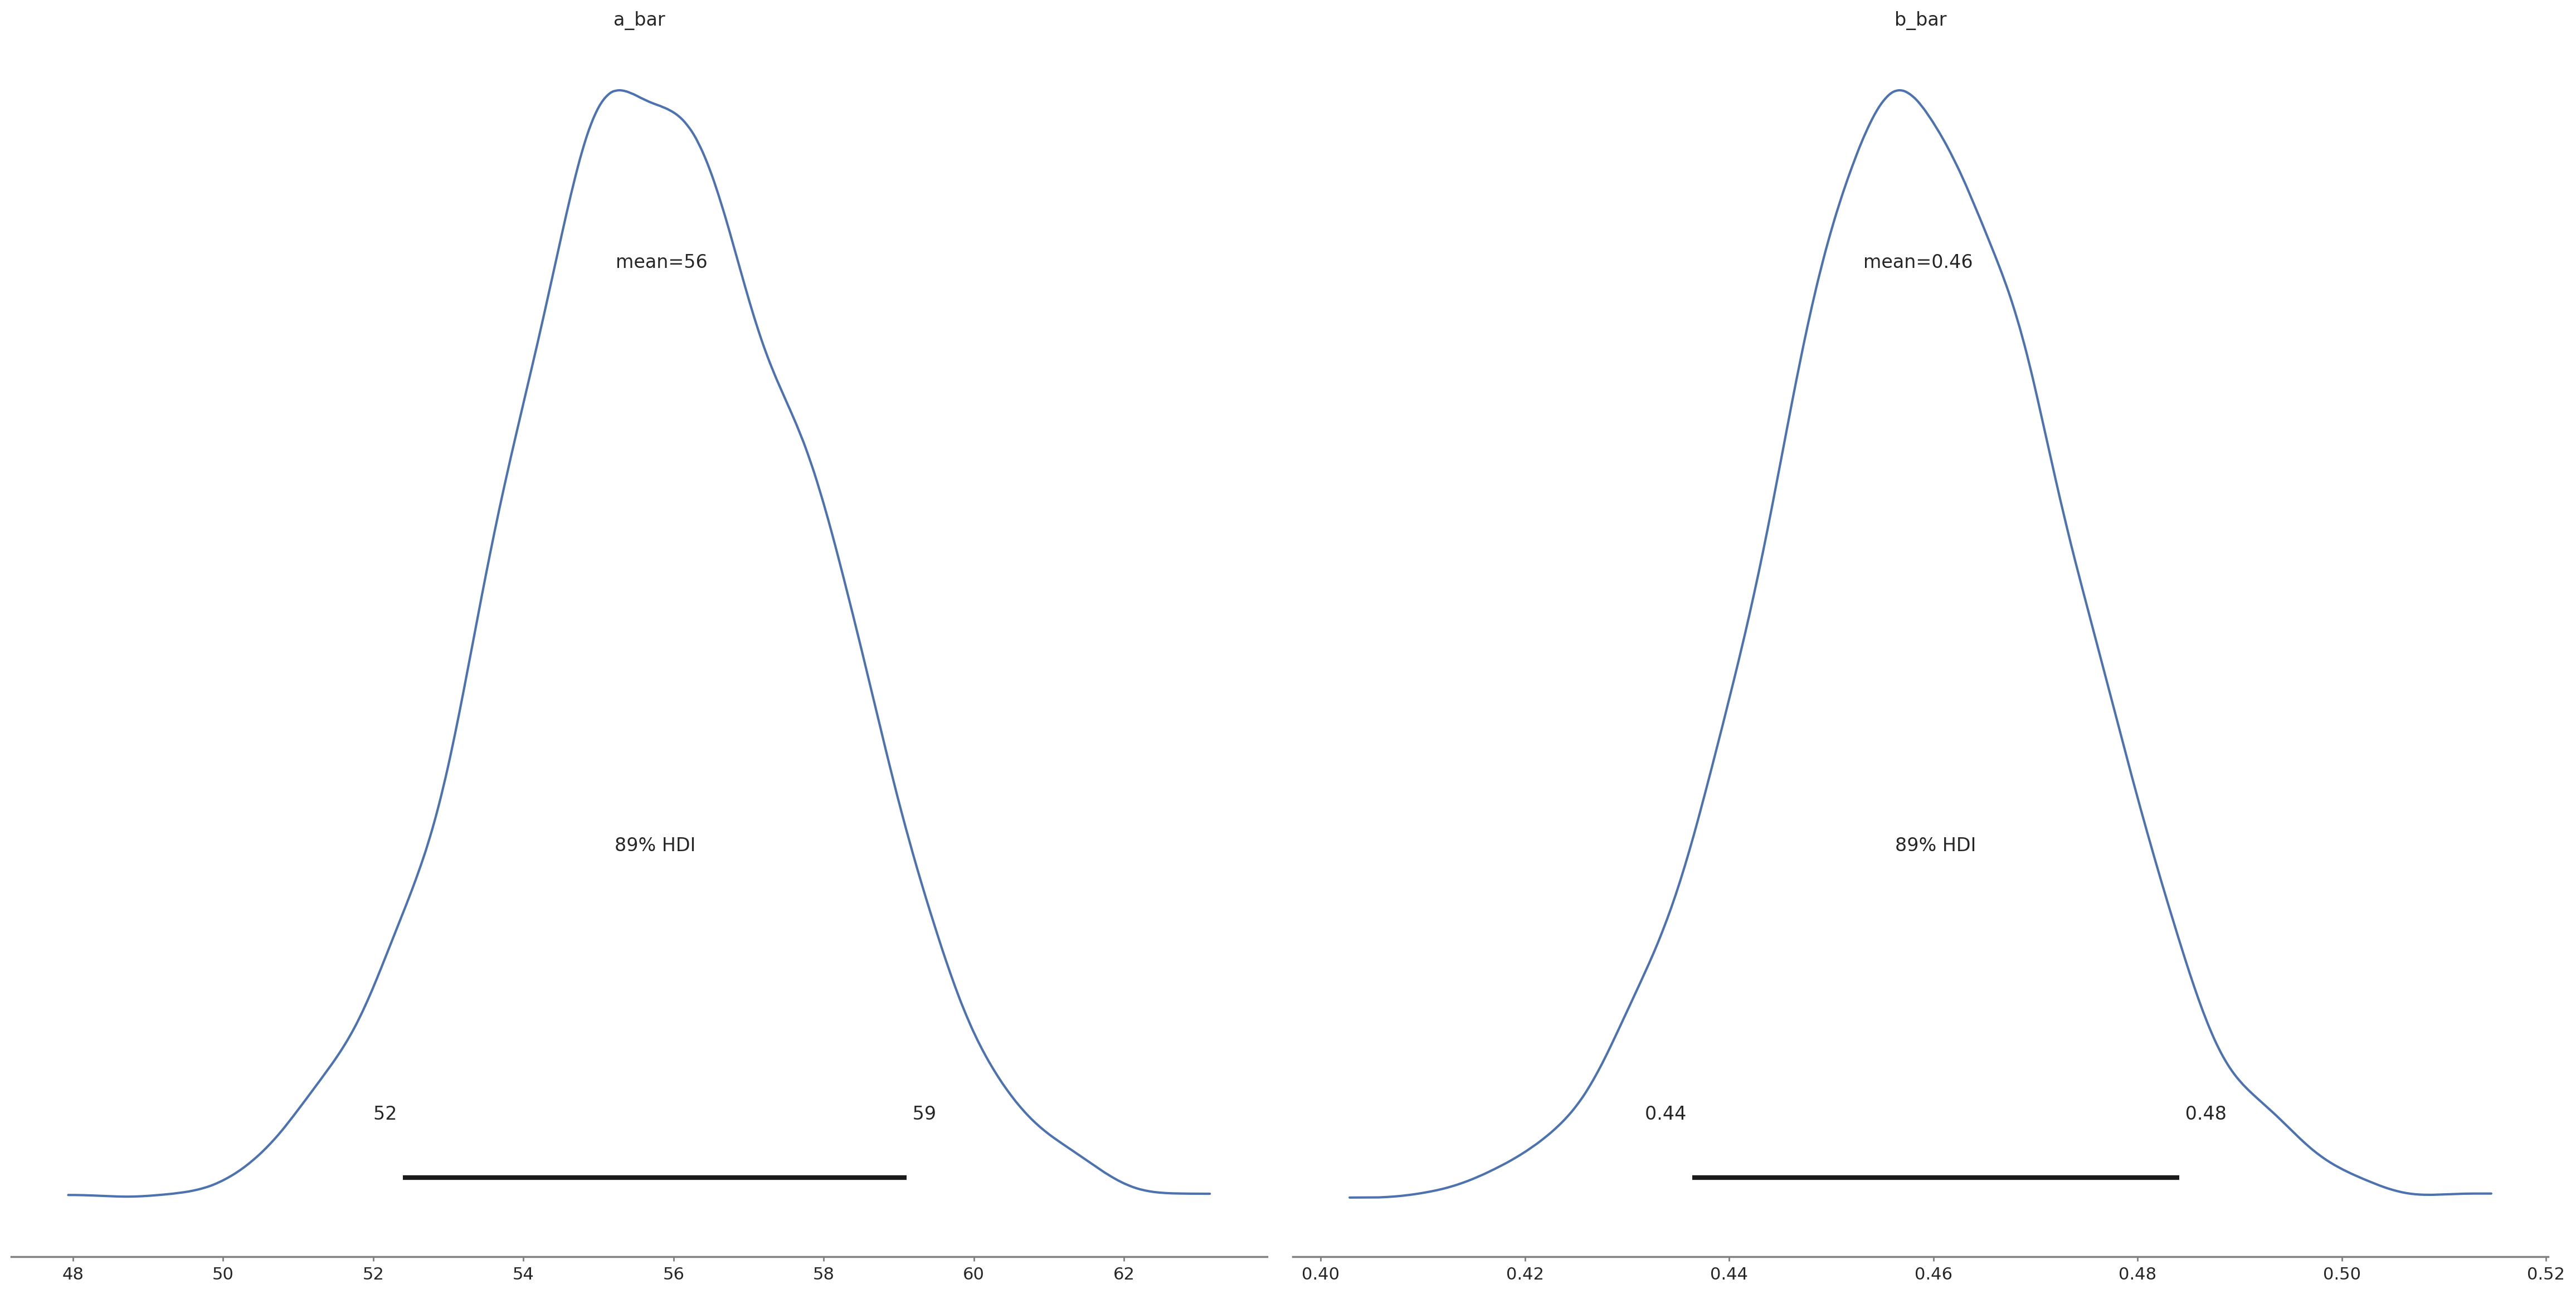

In [310]:
az.plot_posterior(c_1_3_idata, var_names=['a_bar','b_bar'])
#how to check the fitting?

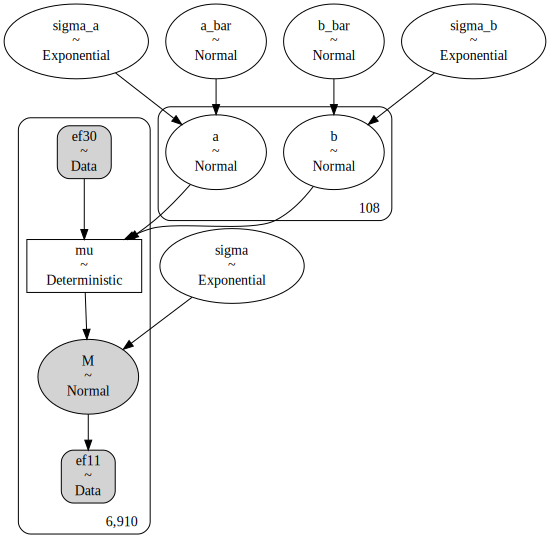

In [382]:
pm.model_graph.model_to_graphviz(c_1_3, formatting='plain')



In [313]:
c_1_3_idata['posterior']['a'].mean(dim=['chain','draw']).values[:]

array([ 54.77981241,  35.61764287,  48.83625966,  58.68476178,
        69.93053642,  50.93975946,  77.58245635,  57.54748295,
        37.529093  ,  60.55457829,  35.42310831,  39.07636234,
        36.74300531,  46.03341248,  49.06630953,  42.91415537,
        40.30502959,  28.27036735,  54.88221301,  43.76330526,
        63.31780975,  32.07063239,  48.39358221,  43.62396923,
        77.63924315,  60.79380301,  54.73607553,  41.36607416,
        50.62719746,  68.98874987,  61.78338487,  63.24097678,
        35.06945245,  76.82258274,  71.71817822,  68.18282614,
        37.79784853,  74.61963062,  46.25901563,  36.63887819,
        61.72889169,  46.21089527,  49.76890581,  33.43445279,
        34.26979866,  36.66596023,  39.91352942,  32.60229168,
        35.4222152 ,  60.647794  ,  35.86437977,  35.48176022,
        39.71340067,  43.37164845,  34.09747052,  47.26552568,
        43.18511509,  41.08170058,  37.15961012,  34.876315  ,
        41.99673699,  39.22297642,  84.02930033,  42.33

In [314]:
cor_a = c_1_3_idata['posterior']['a'].mean(dim=['chain','draw']).values[:]
cor_b = c_1_3_idata['posterior']['b'].mean(dim=['chain','draw']).values
RC = pd.DataFrame({'a': cor_a, 'b':cor_b})
RC['vox']=pd.NA
RC['side']=pd.NA
RC.head()

a         b   vox  side
0  54.779812  0.494351  <NA>  <NA>
1  35.617643  0.418108  <NA>  <NA>
2  48.836260  0.459522  <NA>  <NA>
3  58.684762  0.537703  <NA>  <NA>
4  69.930536  0.638111  <NA>  <NA>

(256, 256, 256)

In [356]:
b_data=template_data.copy();
for i in np.unique(template_data):
    print(i)
    if (i!=0):
        ixs=np.where(template_data==i)
        regt = code.struct_name.iloc[np.where(code['struct_index']==i)]
        ixs2 = np.where(coder.roiname==regt.values[0])
        if (ixs2[0].size!=0):
            k=coder.roi.iloc[ixs2].values[0]
            #b_data[ixs]=((post['b1'][k].mean().values)*1000).round().astype('int') + ((post['a1'][k].mean().values)*1000).round().astype('int')#here we multiply so that no need to deal integer/float issue
            #b_data[ixs]=((post['a1'][k].mean().values)*1000).round().astype('int')/((post['a1'][k].std().values)*1000).round().astype('int')#here we multiply so that no need to deal integer/float issue
            #b_data[ixs]=((post['a1'][k].mean().values)*1000).round().astype('int')#here we multiply so that no need to deal integer/float issue
            b_data[ixs]=((c_1_3_idata['posterior']['b'].mean(dim=['chain','draw']).values[k])*1000).round().astype('int')
            #b_data[ixs]=((c_1_3_idata['posterior']['a'].mean(dim=['chain','draw']).values[k])*1).round().astype('int')
            RC.vox.iloc[k]=ixs[0].shape[0]
            if (pd.Series(regt.values[0]).str.contains('rh').bool() | pd.Series(regt.values[0]).str.contains('Right').bool()):
                RC.side.iloc[k]=1
            else:
                RC.side.iloc[k]=0
            #b_data[ixs]=((ppc['b1'][:,:,2].mean(0)[k])*1000).round().astype('int')
            
        else:
            b_data[ixs]=0 #we overwrite the template data

0
2
4


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

5


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


10
11


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

12
13


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

14
15


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

16
17


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

18
24


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


26
28


/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


30


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


31
41


/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

43
44


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

46
47


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


49
50


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

51
52


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

53
54


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

58
60


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

62
63


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

77
80


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

85
251


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

252
253


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

254
255


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1000
1001


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

1002
1003


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

1005
1006


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

1007
1008


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

1009
1010


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

1011
1012


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

1013
1014


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

1015
1016


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

1017
1018


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

1019
1020


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

1021
1022


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

1023
1024


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

1025
1026


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

1027
1028


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

1029
1030


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

1031
1032


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

1033
1034


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

1035
2000
2001
2002


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

2003
2005


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

2006
2007


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

2008
2009


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

2010
2011


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

2012
2013


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

2014
2015


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

2016
2017


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

2018
2019


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

2020
2021


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

2022
2023


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

2024
2025


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

2026
2027


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

2028
2029


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

2030
2031


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

2032
2033


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

2034
2035


/tmp/ipykernel_24/398575417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24/398575417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [357]:
from nilearn import plotting
new_image_2 = image.new_img_like('/ECT/Abbott/template.nii.gz', b_data)
new_image_2.to_filename('/ECT/Abbott/test_im2.nii.gz')
#plotting.plot_stat_map(new_image)

/opt/conda/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/nilearn/image/resampling.py:531: UserWarning: Casting data from int32 to float32
/opt/conda/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/nilearn/plotting/html_document.py:57: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.



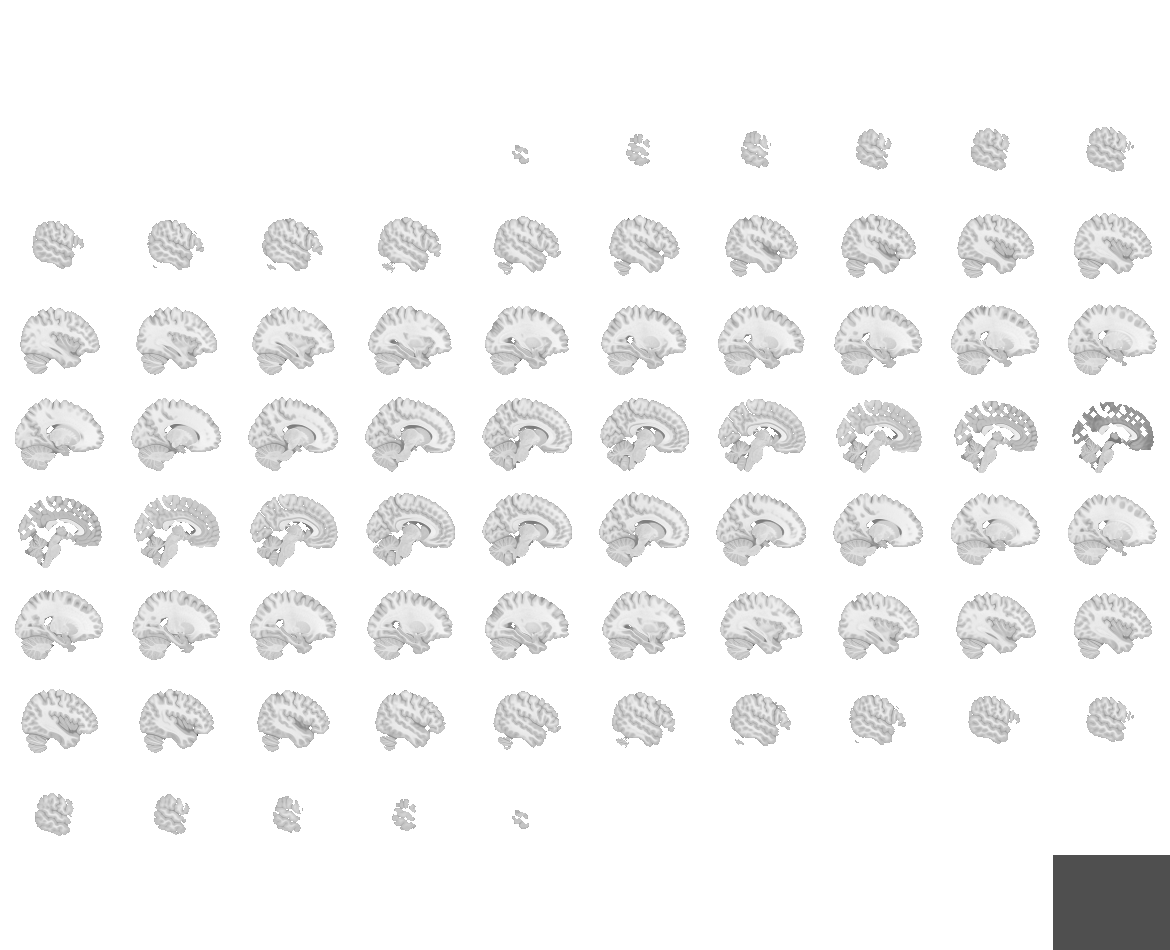
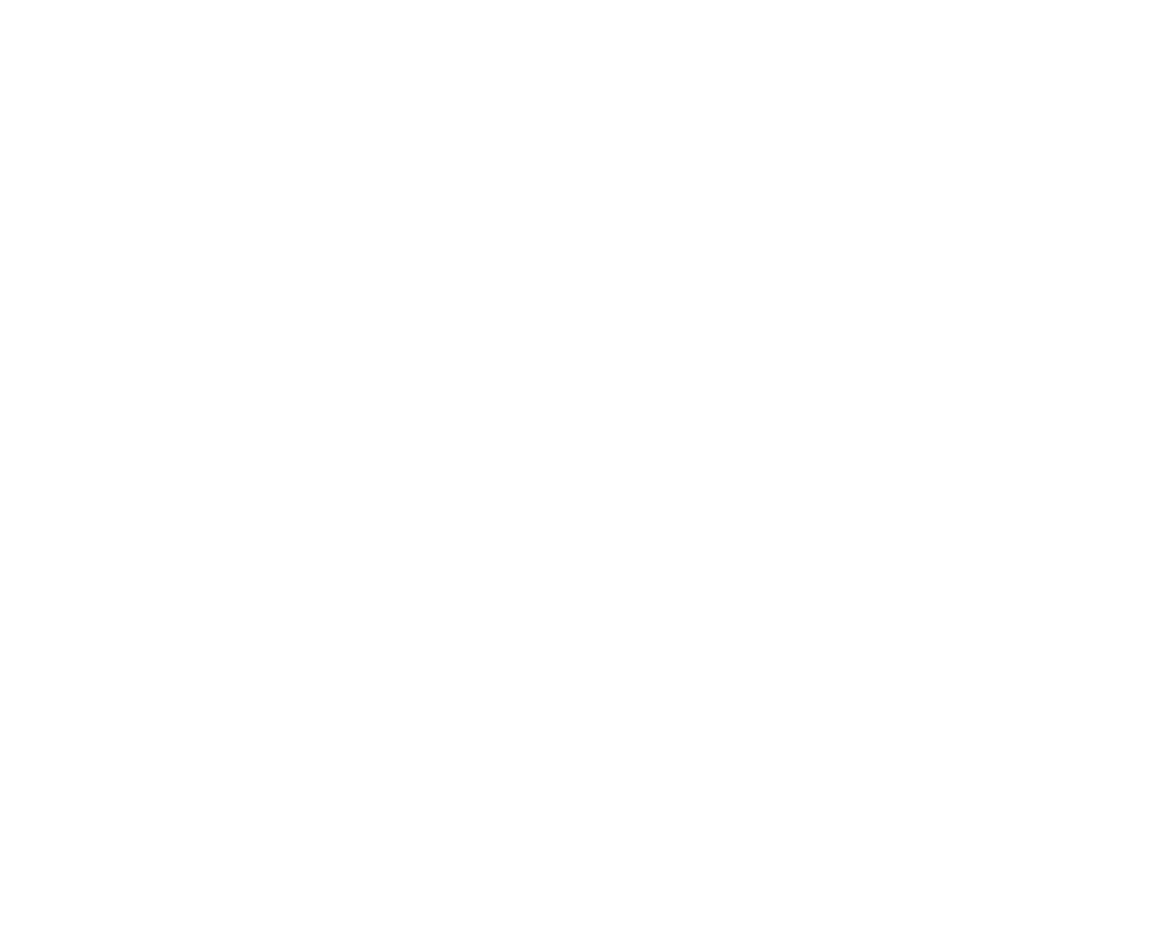

In [403]:
#view = plotting.view_img(new_image, symmetric_cmap=False, vmin=400.0, vmax=700, threshold =100.0, black_bg=False)
view = plotting.view_img(new_image_2, symmetric_cmap=False, vmax=140, black_bg=False)
view

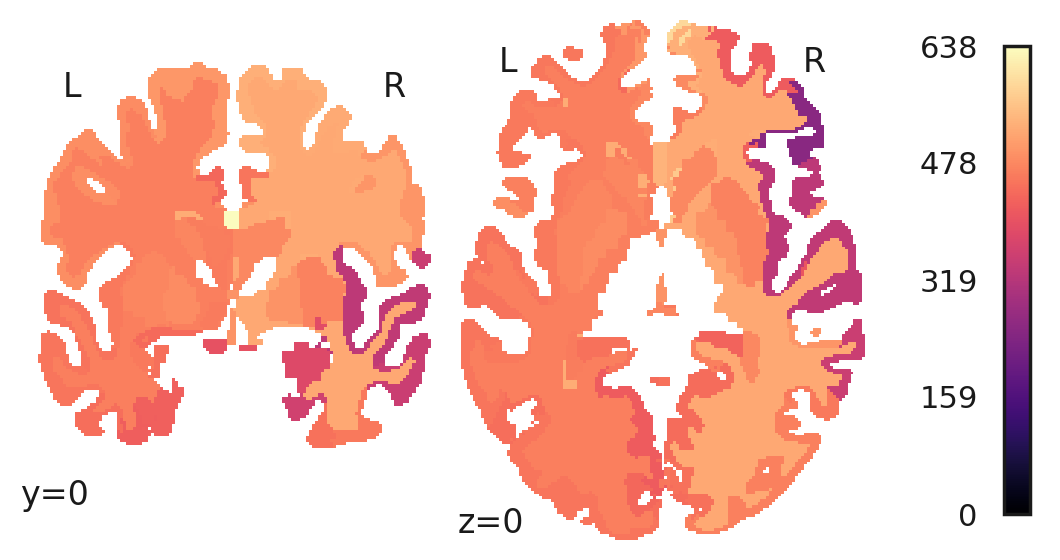

In [362]:
plotting.plot_img(new_image_2, display_mode='yz',cut_coords=(0,0), vmin=0, cmap=plt.cm.magma, threshold =0, black_bg=False, colorbar=True, draw_cross=False, cbar_tick_format="%i")

In [369]:
#pd.melt(RC, value_vars=['a','b'], id_vars='vox')

vox variable      value
0      788        a  54.779812
1     1615        a  35.617643
2    28579        a  48.836260
3      955        a  58.684762
4      471        a  69.930536
..     ...      ...        ...
211  12419        b   0.333724
212   8319        b   0.455239
213   2902        b   0.424865
214   1070        b   0.407737
215     66        b   0.147518

[216 rows x 3 columns]

In [373]:
gridspec

GridSpec(2, 2)

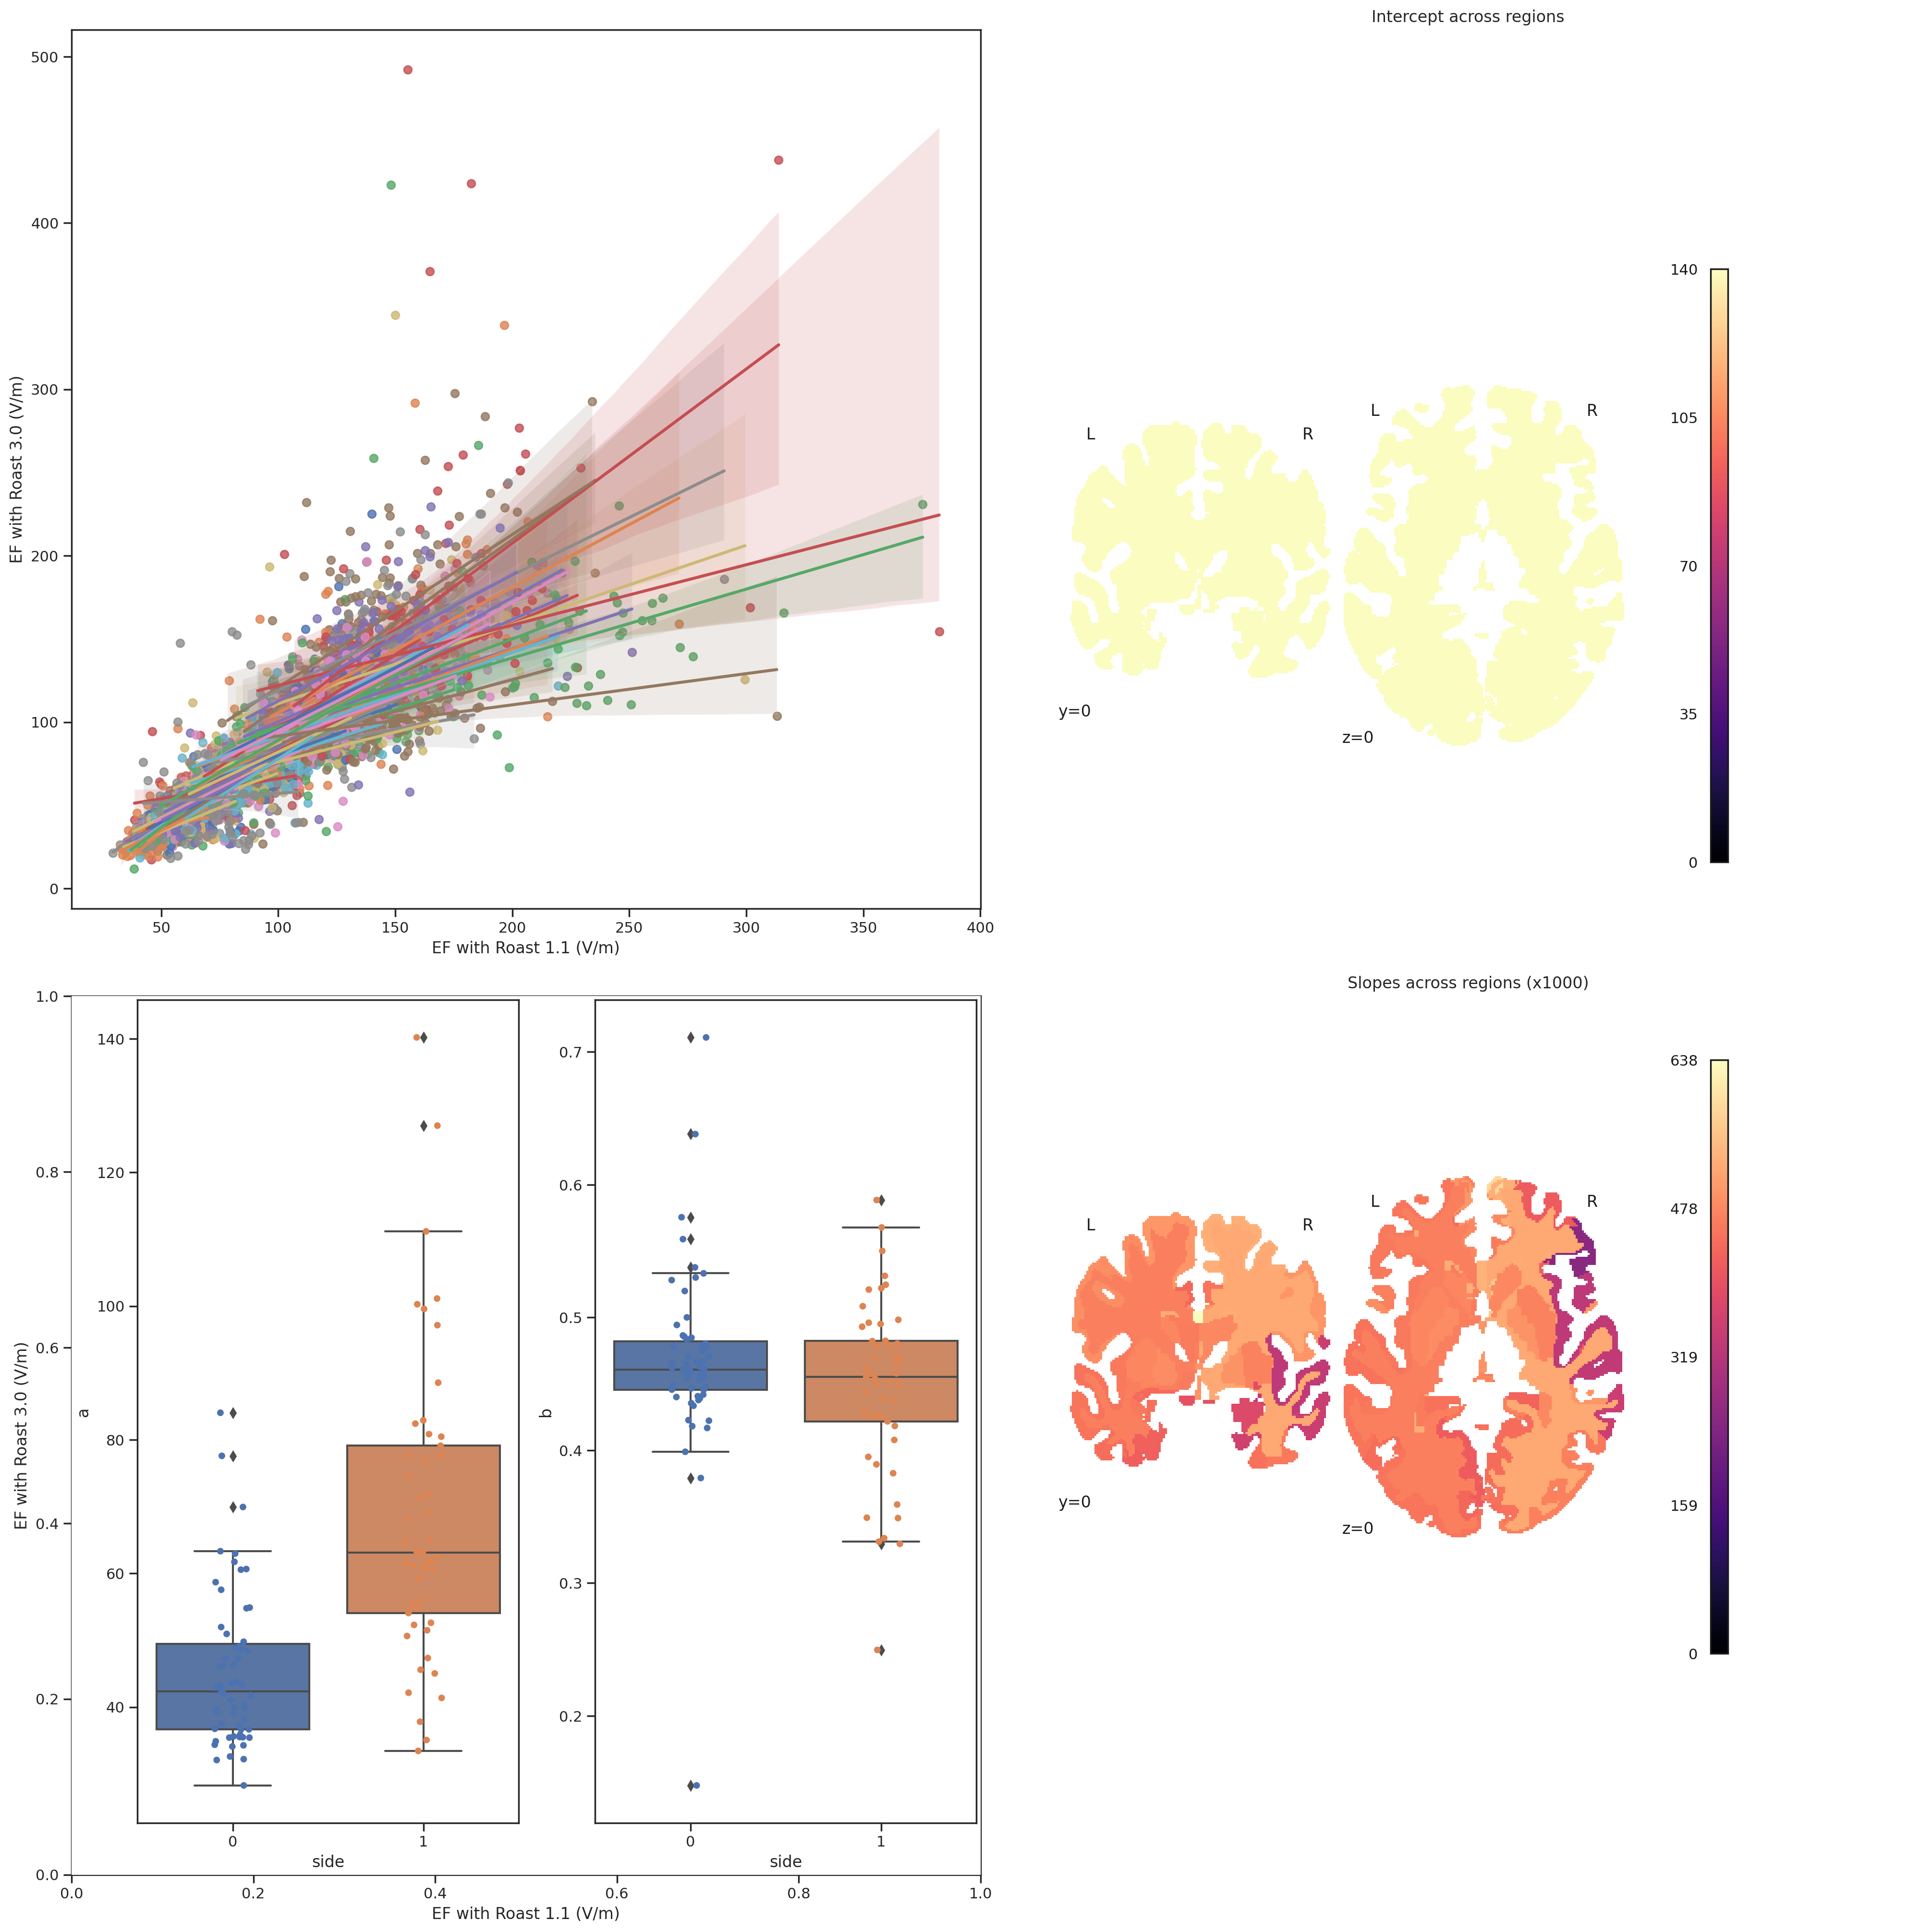

In [401]:
fix, axes = plt.subplots(2,2);
gridspec = axes[1][0].get_subplotspec().get_gridspec()
plt.rcParams['figure.figsize'] = (20,20);
for i in np.unique(datafref.roiind):
    sns.regplot(data=datafref.iloc[np.where(datafref.roiind==i)], x='ef11', y='ef30', ax=axes[0][0]);
    #sl, _, _, _ = np.linalg.lstsq([datafref.ef11.iloc[np.where(datafref.roiind==i)].values], [datafref.ef30.iloc[np.where(datafref.roiind==i)].values]);
    #plt.plot(datafref.ef11.iloc[np.where(datafref.roiind==i)].values, (datafref.ef11.iloc[np.where(datafref.roiind==i)].values)*sl);
#sns.regplot(data=IC, x='age', y='avg', line_kws={'color':'r'}, order=2, ax=axes[1]);
#sns.scatterplot(data=IC, x='age', y='avg', hue='sex', ax=axes[1]);
#sns.scatterplot(data=RC.iloc[np.where(RC.vox<30000)], x='avg', y='std', size='vox', hue='side', ax=axes[0])
subfig = fix.add_subfigure(gridspec[1,0])
axesS=subfig.subplots(1,2)
#sns.boxplot(data=RC, y='side', x='a', orient='h',ax=axes[1][0])
#sns.stripplot(data=RC, y='side', x='a', orient='h', ax=axes[1][0])
sns.boxplot(data=RC, x='side', y='a', orient='v',ax=axesS[0])
sns.stripplot(data=RC, x='side', y='a', orient='v', ax=axesS[0])
sns.boxplot(data=RC, x='side', y='b', orient='v',ax=axesS[1])
sns.stripplot(data=RC, x='side', y='b', orient='v', ax=axesS[1])

plotting.plot_img(new_image_2, display_mode='yz',cut_coords=(0,0), vmin=0, cmap=plt.cm.magma, vmax=140, threshold =0, black_bg=False, colorbar=True, draw_cross=False, cbar_tick_format="%i", axes=axes[0][1])
plotting.plot_img(new_image_2, display_mode='yz',cut_coords=(0,0), vmin=0, cmap=plt.cm.magma, threshold =0, black_bg=False, colorbar=True, draw_cross=False, cbar_tick_format="%i", axes=axes[1][1])

#plotting.plot_img(new_image, display_mode='y', cut_coords=[0], vmin=900.0, vmax=1100, threshold =700.0, black_bg=False, axes=axes[0][1])
#plotting.plot_img(new_image, display_mode='z', cut_coords=[0], vmin=900.0, vmax=1100, threshold =700.0, black_bg=False, axes=axes[1][1], colorbar=True)
axes[0][0].set_xlabel('EF with Roast 1.1 (V/m)')
axes[0][0].set_ylabel('EF with Roast 3.0 (V/m)')
axes[1][0].set_xlabel('EF with Roast 1.1 (V/m)')
axes[1][0].set_ylabel('EF with Roast 3.0 (V/m)')

axes[0][1].set_title('Intercept across regions')
axes[1][1].set_title('Slopes across regions (x1000)')

#axes[1].set_ylabel('Slope between EF1.1 and EF3.0')
plt.savefig('/ECT/Bergen/Compare11vs30/regional-differencies-aAb-are-related-to-side.pdf');
plt.show();

In [1438]:
cd = np.unique(clinuse[['sess', 'sbj']], axis=0)
res = pd.DataFrame(columns=['sess','sbj','slope'])
#res.astype({'sess': 'int','sbj': 'int','slope': 'float'}).dtypes
for i in range(code.shape[0]):
    #print(i)
    ideg = pd.DataFrame([cd[i][0], cd[i][1], c_1_1_idata['posterior']['b'].mean(dim=['chain','draw']).values[i]]).T
    ideg.columns=['sess','sbj','slope']
    res = pd.concat([res, ideg], ignore_index=True)
res    
res.to_csv('/ECT/TMS/NBACK/clin-slope.csv')

sess   sbj     slope
0   22847.0   0.0 -0.822532
1   22862.0   1.0 -0.955178
2   22875.0   3.0 -1.050201
3   22876.0   2.0 -0.660578
4   22886.0   4.0 -1.309123
..      ...   ...       ...
36  23657.0  36.0 -1.062332
37  23712.0  35.0 -2.965105
38  23747.0  38.0 -0.857503
39  23760.0  39.0 -3.253172
40  23802.0  40.0 -0.515856

[41 rows x 3 columns]

In [1406]:
c_1_1_idata['posterior']['b'].mean(dim=['chain','draw']).values[i]

-0.8225324603143541

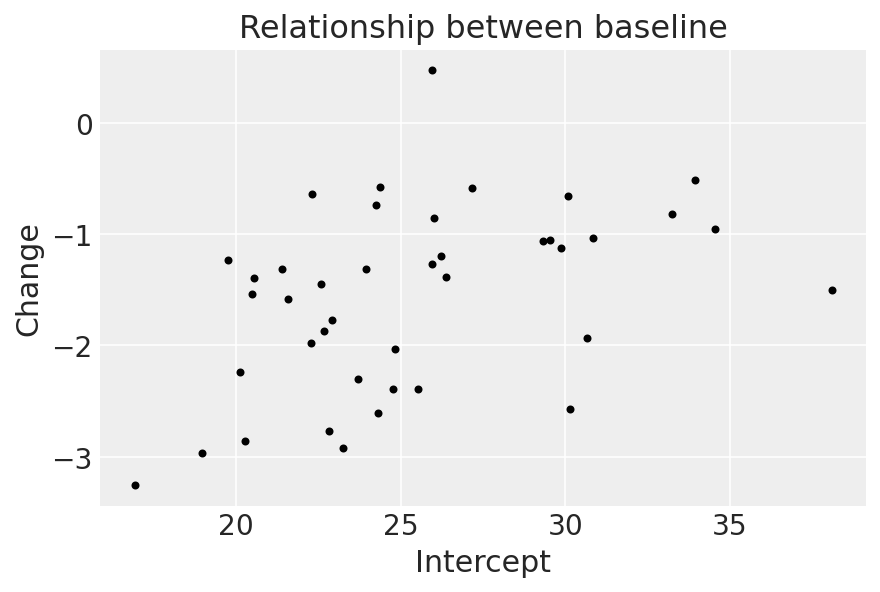

In [1391]:
c_1_1_idata['posterior']['b'].mean(dim=['chain','draw']).values
fig, ax = plt.subplots(1,1)
ax.plot(c_1_1_idata['posterior']['a'].mean(dim=['chain','draw']).values,c_1_1_idata['posterior']['b'].mean(dim=['chain','draw']).values, ".k")
#ax.plot(x_train1, ppc["observed"][::10].T, ".k", alpha=0.1)
#ax.plot(clinuse.time, prior["mu"][::10].T, ".k", alpha=0.1)
ax.set_xlabel("Intercept")
ax.set_ylabel("Change")
ax.set_title("Relationship between baseline and change");

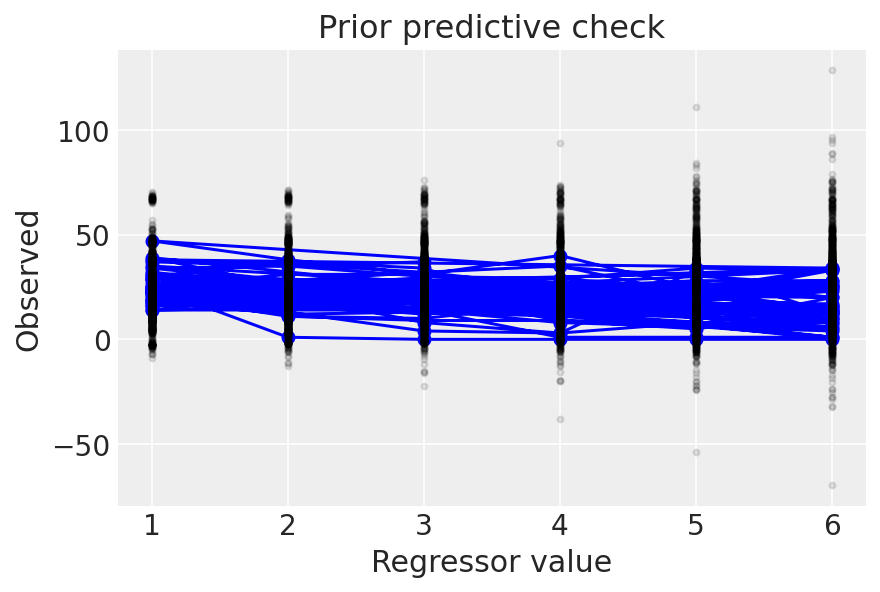

In [1392]:
fig, ax = plt.subplots(1,1)
ax.plot(clinuse.time, clinuse.madrs, "-ob")
#ax.plot(x_train1, ppc["observed"][::10].T, ".k", alpha=0.1)
ax.plot(clinuse.time, prior["mu"][::10].T, ".k", alpha=0.1)
ax.set_xlabel("Regressor value")
ax.set_ylabel("Observed")
ax.set_title("Prior predictive check");

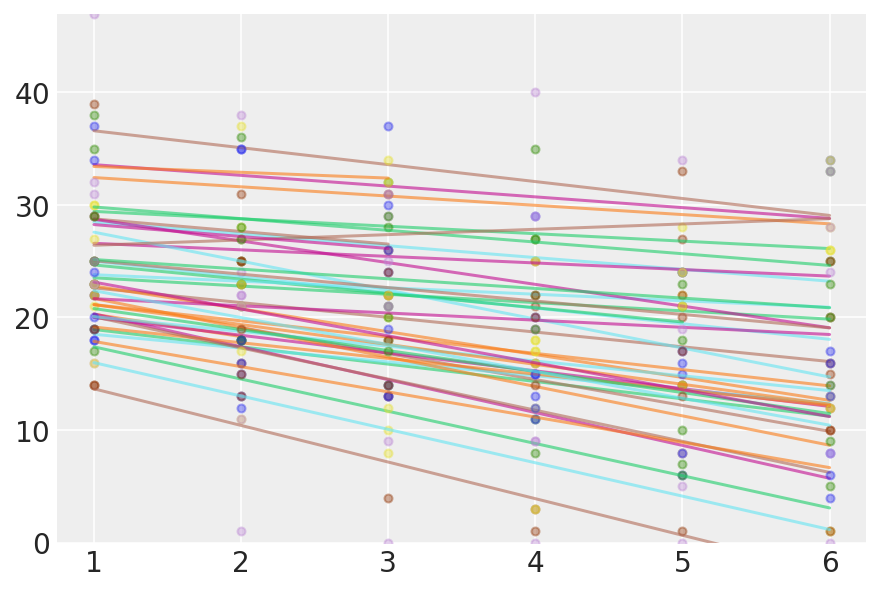

In [1361]:
_, ax = plt.subplots()

for i in range(41):
  
  mreg=i
  ix = np.where(clinuse.sbj==mreg)[0]
  if (ix.size!=0):
    ax.plot(clinuse.time.iloc[ix], clinuse.madrs.iloc[ix], "o", ms=4, alpha=0.4, label="Data") 
    #m, b = np.polyfit(clinuse.madrs.iloc[ix], ppc["M"].mean(0)[ix],1)
    ax.plot(clinuse.time.iloc[ix], c_1_1_idata['posterior']['b'][:,:,mreg].mean().values*clinuse.time.iloc[ix]+c_1_1_idata['posterior']['a'][:,:,mreg].mean().values, label="Mean outcome", alpha=0.6)
    #ax.set_title('Subject: ' + str(i))

    #plt.savefig('./Abbott/testfig_'+str(i)+'.pdf')
    #plt.show()
  #print(i)
plt.ylim([0,clinuse.madrs.values.max()])
plt.show();

/opt/conda/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (318) in plot_posterior, generating only 40 plots
  warnings.warn(


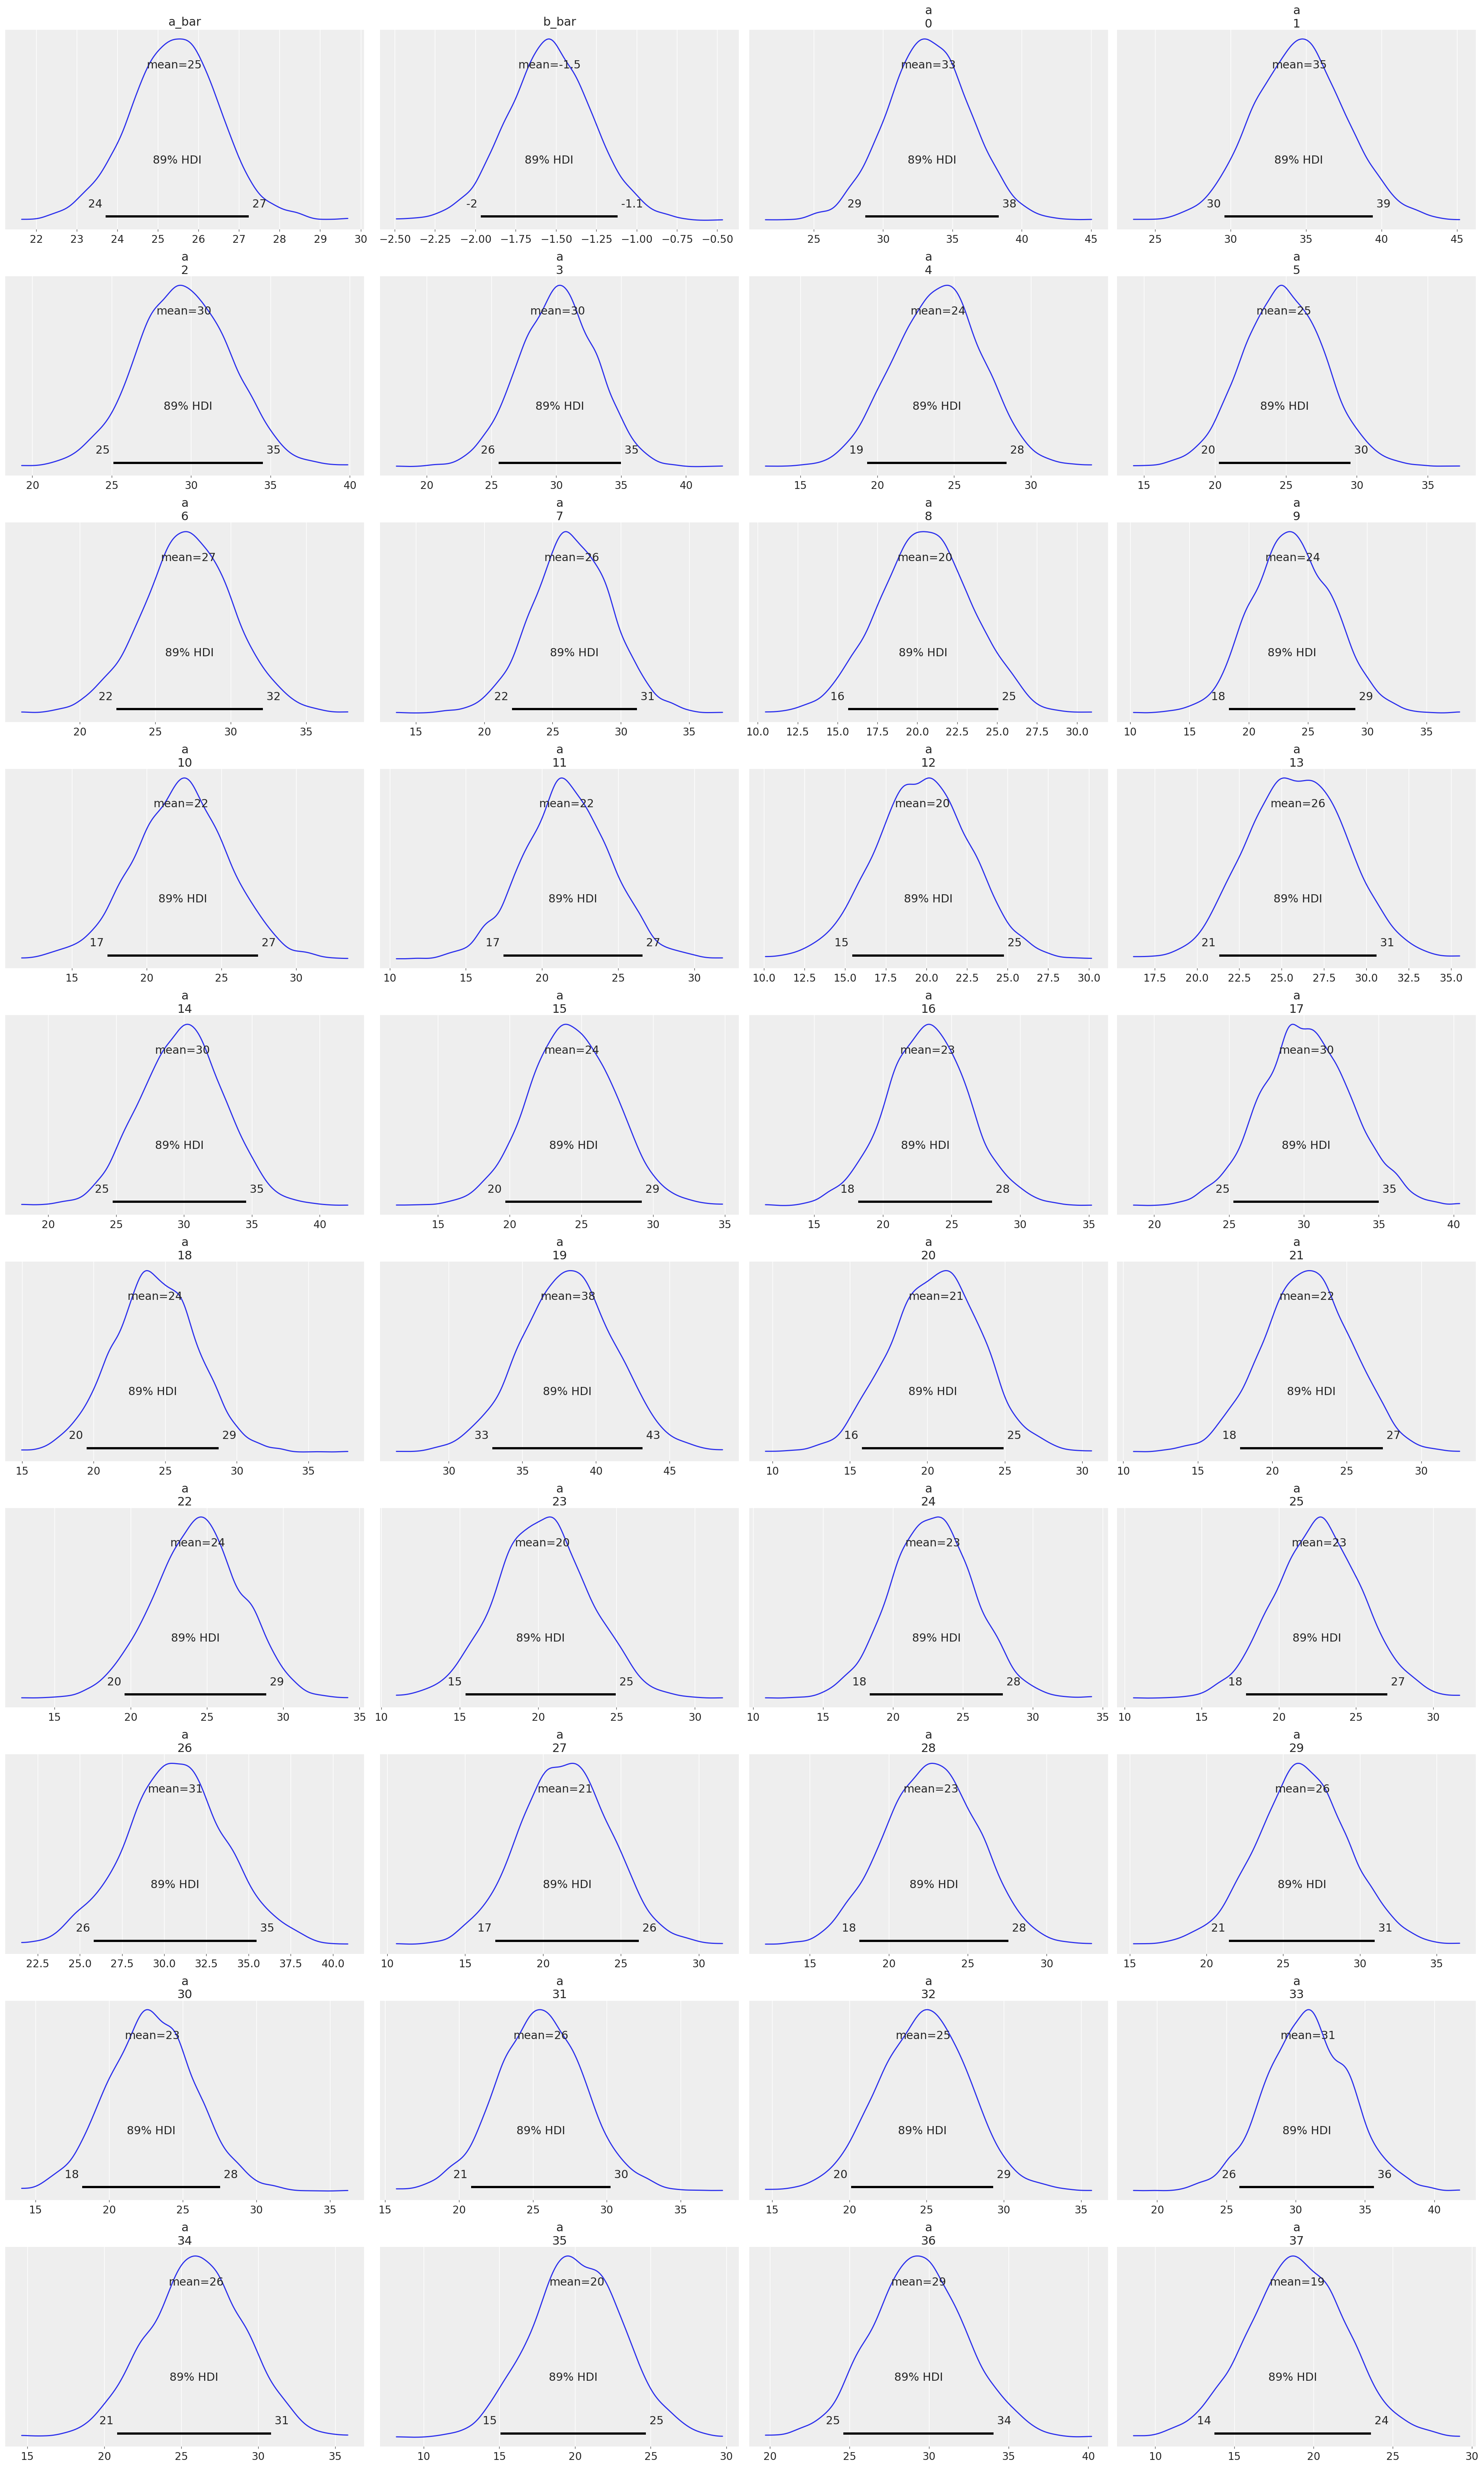

In [1395]:
az.plot_posterior(c_1_1_idata);